In [ ]:
import os

def change_dir_in_hipergator():
    # this env var is set on hipergator (SLURM is the job scheduler there)
    if os.getenv("SLURM_JOB_ID", None):
        target_dir = "diff_fam_social_memory_ephys"
        current = os.getcwd()

        while True:
            parent = os.path.dirname(current)
            # If we've reached the root directory without finding the target
            if parent == current:
                raise FileNotFoundError(f"Could not find parent directory '{target_dir}'")

            # Check if the target directory is the current parent's name
            if os.path.basename(parent) == target_dir:
                os.chdir(parent)
                return parent

            current = parent

# Usage
try:
    new_path = change_dir_in_hipergator()
    print(f"Successfully changed to directory: {new_path}")
except FileNotFoundError as e:
    print(e)
    
import pandas as pd
import numpy as np
import lfp.lfp_analysis.LFP_collection as LFP_collection
import lfp.lfp_analysis.Analysis as lfpa
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
import lfp.lfp_analysis.LFP_analysis as lfpa
from itertools import combinations, permutations
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from lfp.lfp_analysis.LFP_collection import LFPCollection
from lfp.lfp_analysis.LFP_recording import LFPRecording
from importlib import reload
from scipy.signal import find_peaks
from sklearn.decomposition import NMF
def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl
    Returns:
        none
    """
    with open(file_name, "wb") as file:
        pickle.dump(thing_to_pickle, file)


def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, "rb") as file:
        return pickle.load(file)
    


cups_lfp_json = "data/cups_lfp/lfp_collection.json"

cups_collection = LFP_collection.LFPCollection.load_collection(cups_lfp_json)
behavior_dicts = unpickle_this('pilot2/cups_phase4/cups_behavior_dicts.pkl')

for recording in cups_collection.lfp_recordings:
    subject = str(int(recording.name.split('_')[0])/10)
    recording_pattern = (recording.name.split('_')[0] + '_' +
                         recording.name.split('_')[1] + '_' +
                         recording.name.split('_')[2] + '_' +
                         'aggregated')
    recording.behavior_dict = behavior_dicts[subject]
    recording.subject = subject
    recording.subject = subject
test_rec = cups_collection.lfp_recordings[0]
cups_collection.brain_region_dict = test_rec.brain_region_dict


Successfully changed to directory: /blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys


/blue/npadillacoreano/mcum/conda/envs/lfp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot_spectogram(lfp_collection, events, mode, event_len, baseline=None, pre_window = 0, post_window = 0, freq_range=(0,100)):
      # Process collection vs single recording
    if isinstance(lfp_collection, LFPCollection):
        recordings = lfp_collection.lfp_recordings
    elif isinstance(lfp_collection, LFPRecording):
        recordings = [lfp_collection]
    else:
        raise TypeError("lfp_collection must be either LFPCollection or LFPRecording")
    
    # Dictionary to store the average event data for each event type
    event_averages_dict = {}
    
    # Process each event type
    for i in range(len(events)):
        all_events = []
        for recording in recordings:
            # Events shape: [trials, time, freq, regions]
            recording_events = lfpa.__get_events__(recording, events[i], mode, event_len, 
                                                  pre_window, post_window, average=False)
            
            if baseline is not None:
                adj_averages = lfpa.__baseline_diff__(
                    recording, recording_events, baseline[i], mode, event_len, 
                    pre_window=0, post_window=0, average = False
                )
                all_events.extend(adj_averages)
            else:
                all_events.extend(recording_events)
        
        # Calculate average across trials for this event type
        average_event = np.nanmean(np.array(all_events), axis=0)
        event_averages_dict[events[i]] = average_event
    
    # Get dimensions and axes from the first event (assuming all have same shape)
    first_event = list(event_averages_dict.values())[0]
    n_timepoints, n_freqs, n_regions = first_event.shape
    time_axis = np.linspace(-pre_window, event_len+post_window, n_timepoints)
    freq_axis = range(freq_range[0], freq_range[1])
    
    # Get region names
    region_names = [f'{cups_collection.brain_region_dict.inverse[i]}' for i in range(n_regions)]
    
    # Calculate vmin and vmax per brain region across all events
    region_bounds = []
    for region_idx in range(n_regions):
        # Collect data for this region across all events
        region_data = np.array([])
        for event_data in event_averages_dict.values():
            # Extract only the frequency range we want to display
            sliced_data = event_data[:, freq_range[0]:freq_range[1], region_idx]
            if region_data.size == 0:
                region_data = sliced_data.flatten()
            else:
                region_data = np.concatenate([region_data, sliced_data.flatten()])
        
        # Calculate percentiles for this region's data
        region_vmin = np.percentile(region_data, 5)  # 5th percentile to avoid outliers
        region_vmax = np.percentile(region_data, 95)  # 95th percentile to avoid outliers
        
        # Store bounds for this region
        region_bounds.append((region_vmin, region_vmax))
    
    # Setup figure layout - rows are brain regions, columns are event types
    n_rows = n_regions
    n_cols = len(events)
    
    # Adjust figure size based on number of subplots
    fig_size = (15, 10)
    adjusted_width = max(fig_size[0], 4 * n_cols)
    adjusted_height = max(fig_size[1], 3 * n_rows)
    
    # Create figure with extra space for everything
    fig = plt.figure(figsize=(adjusted_width + 4, adjusted_height))
    
    # Create layout with extra space for labels and colorbars
    # Main gridspec for all content
    outer_gs = fig.add_gridspec(1, 2, width_ratios=[0.15, 0.85], wspace=0.0)
    
    # Left side for region labels
    labels_gs = outer_gs[0].subgridspec(n_rows, 1)
    
    # Right side for plots and colorbars
    right_gs = outer_gs[1].subgridspec(1, 2, width_ratios=[0.95, 0.015], wspace=0.01)
    
    # Further divide the plots area into a grid for each region and event
    plots_gs = right_gs[0].subgridspec(n_rows, n_cols, hspace=0.3, wspace=0.3)
    
    # And the colorbar area into a column for each region
    cbar_gs = right_gs[1].subgridspec(n_rows, 1)
    
    # Create axes
    label_axes = []
    plot_axes = []
    cbar_axes = []
    
    # Create label axes
    for row_idx in range(n_rows):
        label_ax = fig.add_subplot(labels_gs[row_idx, 0])
        label_ax.axis('off')  # Hide axis elements
        label_axes.append(label_ax)
    
    # Create plot axes
    for row_idx in range(n_rows):
        row_axes = []
        for col_idx in range(n_cols):
            ax = fig.add_subplot(plots_gs[row_idx, col_idx])
            row_axes.append(ax)
        plot_axes.append(row_axes)
    
    # Create colorbar axes
    for row_idx in range(n_rows):
        cbar_ax = fig.add_subplot(cbar_gs[row_idx, 0])
        cbar_axes.append(cbar_ax)
    
    # Add the region labels
    for row_idx, region_idx in enumerate(range(n_regions)):
        if row_idx < len(region_names):
            label_axes[row_idx].text(0.5, 0.5, region_names[region_idx],
                                     fontsize=18, fontweight='bold',
                                     rotation=90, ha='center', va='center',
                                     transform=label_axes[row_idx].transAxes)
    
    # Plot spectrograms and add colorbars
    for row_idx, region_idx in enumerate(range(n_regions)):
        region_vmin, region_vmax = region_bounds[region_idx]
        
        # Reference to store the last image for colorbar
        region_im = None
        
        # Plot each event for this region
        for col_idx, event in enumerate(events):
            ax = plot_axes[row_idx][col_idx]
            
            # Get the event data for this specific region
            event_data = event_averages_dict[event][:, freq_range[0]:freq_range[1], region_idx].T
            
            # Plot the spectrogram
            im = ax.pcolormesh(time_axis, freq_axis, event_data,
                              cmap='viridis', vmin=region_vmin, vmax=region_vmax, shading='gouraud')
            
            region_im = im  # Save for colorbar
            
            # Add vertical line at t=0 (event onset)
            ax.axvline(x=0, color='white', linestyle='--', alpha=0.7)
            
            # Set labels only on left and bottom edges
            if col_idx == 0:
                ax.set_ylabel('Frequency (Hz)')
            
            if row_idx == n_rows - 1:
                ax.set_xlabel('Time (s)')
            
            # Add event type title
            if row_idx == 0:
                ax.set_title(f"{event}", fontsize=14, fontweight='bold')
        
        # Add colorbar for this region
        if region_im is not None:
            cbar = plt.colorbar(region_im, cax=cbar_axes[row_idx])
            cbar.set_label('Power', rotation=270, labelpad=15)
            
def plot_power_averages(lfp_collection, event_averages, freq_range, peak_height, peak_width, distance, threshold_percent=50, range_limit = None):
    import numpy as np
    from scipy import stats
    from scipy.signal import find_peaks
    import matplotlib.pyplot as plt
    

    regions = lfp_collection.brain_region_dict.keys()
    if freq_range is None:
        freq_range = [1, 101]
    ranges = []
    for region in regions:
        plt.figure(figsize=(10, 5))
        for event, averages in event_averages.items():
            # averages = [trials, f, b]
            averages = event_averages[event]
            event_average = np.nanmean(averages, axis=0)
            # event_average = [f,b]; average across all trials
            # calculate sem for the trial average
            event_sem = stats.sem(averages, axis=0, nan_policy="omit")
            region_index = lfp_collection.brain_region_dict[region]
            # pick only the region of interest
            y = event_average[freq_range[0]:freq_range[1], region_index]
            y_sem = event_sem[freq_range[0]:freq_range[1], region_index]
            x = range(freq_range[0], freq_range[1])
            (line,) = plt.plot(x, y, label=event)
            plt.fill_between(x, y - y_sem, y + y_sem, alpha=0.2, color=line.get_color())
            
            # Find peaks and mark them with red dots
            peak_indices, properties = find_peaks(y, height=peak_height, width=peak_width, distance = distance)
            # Adjust indices to match the x range
            peak_x = [x[i] for i in peak_indices]
            peak_y = [y[i] for i in peak_indices]
            plt.scatter(peak_x, peak_y, color='red', s=80, zorder=3)
            trough_indices, _ = find_peaks(-y, height=peak_height, width=peak_width, distance = distance)  # Negate data to find troughs
            trough_x = [x[i] for i in trough_indices]
            trough_y = [y[i] for i in trough_indices]
            plt.scatter(trough_x, trough_y, color='blue', s=80, zorder=3, label='_nolegend_')
            ranges_interest = []
            for i, peak_idx in enumerate(peak_indices):
                peak_value = y[peak_idx]
                threshold = peak_value * (threshold_percent / 100)
                
                # Find left boundary (point that passes threshold on the left)
                left_idx = peak_idx
                while left_idx > 0 and y[left_idx] > threshold:
                    left_idx -= 1
                
                # Find right boundary (point that passes threshold on the right)
                right_idx = peak_idx
                while right_idx < len(y) - 1 and y[right_idx] > threshold:
                    right_idx += 1
                
                # Highlight this region
                if range_limit is not None:
                    if right_idx - left_idx > range_limit:
                        plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='orange', label='_nolegend_')
                        ranges_interest.append([left_idx, right_idx])
                else:  
                    plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='orange', label='_nolegend_')
                    ranges_interest.append([left_idx, right_idx])
            # Process each trough
            for i, trough_idx in enumerate(trough_indices):
                trough_value = y[trough_idx]
                # For troughs, we want to find where the signal rises above X% of the distance from the trough to the baseline
                # Estimate "baseline" as the mean of the signal
                baseline = np.mean(y)
                # Calculate the threshold as a point X% of the way from trough to baseline
                threshold = trough_value + (baseline - trough_value) * (threshold_percent / 100)
                
                # Find left boundary (point that passes above threshold on the left)
                left_idx = trough_idx
                while left_idx > 0 and y[left_idx] < threshold:
                    left_idx -= 1
                
                # Find right boundary (point that passes above threshold on the right)
                right_idx = trough_idx
                while right_idx < len(y) - 1 and y[right_idx] < threshold:
                    right_idx += 1
                
                # Highlight this region
                if range_limit is not None: 
                    if right_idx - left_idx > range_limit:
                        plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='lightblue', label='_nolegend_')
                        ranges_interest.append([left_idx, right_idx])
                else:
                    plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='lightblue', label='_nolegend_')
                    ranges_interest.append([left_idx, right_idx])
        ranges.append(ranges_interest)
        ymin, ymax = plt.ylim()
        # plt.axvline(x=12, color="gray", linestyle="--", linewidth=0.5)
        # plt.axvline(x=4, color="gray", linestyle="--", linewidth=0.5)
        # plt.fill_betweenx(y=np.linspace(ymin, ymax, 80), x1=4, x2=12, color="red", alpha=0.1)
        plt.ylim(ymin, ymax)
        plt.title(f"{region} power")
        plt.legend()
        plt.show()
    return ranges

def plot_coherence_averages(lfp_collection, event_averages, freq_range, peak_height, peak_width, distance, threshold_percent=50, range_limit = None):

    brain_regions = list(lfp_collection.brain_region_dict.values())
    pair_indices = list(combinations(brain_regions, 2))
    #ranges = []
    coherence_ranges = [[[] for _ in brain_regions] for _ in brain_regions]
    if freq_range is None:
        freq_range = [1,101]
    for i in range(len(pair_indices)):
        for event, averages in event_averages.items():
            # averages = [trials, f, b, b]
            first_region, second_region = list(pair_indices[i])
            first_region_name = lfp_collection.brain_region_dict.inverse[first_region]
            second_region_name = lfp_collection.brain_region_dict.inverse[second_region]
            averages = event_averages[event]
            event_average = np.nanmean(np.array(averages), axis=0)
            # event_average = [f, b, b]; average across all trials
            # calculate sem for the trial average
            event_sem = stats.sem(averages, axis=0, nan_policy="omit")
            # pick only the region of interest
            y_sem = event_sem[freq_range[0]:freq_range[1], first_region, second_region]
            y = event_average[freq_range[0]:freq_range[1], first_region, second_region]
            x = range(freq_range[0],freq_range[1])
            (line,) = plt.plot(x, y, label=event)
            plt.fill_between(x, y - y_sem, y + y_sem, color=line.get_color(), alpha=0.2)
            # Find peaks and mark them with red dots
            peak_indices, properties = find_peaks(y, height=peak_height, width=peak_width, distance = distance)
            # Adjust indices to match the x range
            peak_x = [x[i] for i in peak_indices]
            peak_y = [y[i] for i in peak_indices]
            plt.scatter(peak_x, peak_y, color='red', s=80, zorder=3)
            trough_indices, _ = find_peaks(-y, height=peak_height, width=peak_width, distance = distance)  # Negate data to find troughs
            trough_x = [x[i] for i in trough_indices]
            trough_y = [y[i] for i in trough_indices]
            plt.scatter(trough_x, trough_y, color='blue', s=80, zorder=3, label='_nolegend_')
            ranges_interest = []
            for i, peak_idx in enumerate(peak_indices):
                peak_value = y[peak_idx]
                threshold = peak_value * (threshold_percent / 100)
                
                # Find left boundary (point that passes threshold on the left)
                left_idx = peak_idx
                while left_idx > 0 and y[left_idx] > threshold:
                    left_idx -= 1
                
                # Find right boundary (point that passes threshold on the right)
                right_idx = peak_idx
                while right_idx < len(y) - 1 and y[right_idx] > threshold:
                    right_idx += 1
                
                # Highlight this region
                if range_limit is not None:
                    if right_idx - left_idx > range_limit:
                        plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='orange', label='_nolegend_')
                        ranges_interest.append([left_idx, right_idx])
                else:
                    plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='orange', label='_nolegend_')
                    ranges_interest.append([left_idx, right_idx])
            # Process each trough
            for i, trough_idx in enumerate(trough_indices):
                trough_value = y[trough_idx]
                # For troughs, we want to find where the signal rises above X% of the distance from the trough to the baseline
                # Estimate "baseline" as the mean of the signal
                baseline = np.mean(y)
                # Calculate the threshold as a point X% of the way from trough to baseline
                threshold = trough_value + (baseline - trough_value) * (threshold_percent / 100)
                
                # Find left boundary (point that passes above threshold on the left)
                left_idx = trough_idx
                while left_idx > 0 and y[left_idx] < threshold:
                    left_idx -= 1
                
                # Find right boundary (point that passes above threshold on the right)
                right_idx = trough_idx
                while right_idx < len(y) - 1 and y[right_idx] < threshold:
                    right_idx += 1
                
                # Highlight this region
                if range_limit is not None: 
                    if right_idx - left_idx > range_limit:
                        plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='lightblue', label='_nolegend_')
                        ranges_interest.append([left_idx, right_idx])
                else:
                    plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='lightblue', label='_nolegend_')
                    ranges_interest.append([left_idx, right_idx])
        coherence_ranges[first_region][second_region] = ranges_interest
        ymin, ymax = plt.ylim()
        # plt.axvline(x=12, color="gray", linestyle="--", linewidth=0.5)
        # plt.axvline(x=4, color="gray", linestyle="--", linewidth=0.5)
        # plt.fill_betweenx(y=np.linspace(ymin, ymax, 80), x1=4, x2=12, color="red", alpha=0.1)
        plt.ylim(ymin, ymax)
        plt.title(f"{first_region_name} & {second_region_name} coherence")
        plt.legend()
        plt.show()
    return coherence_ranges

def plot_granger_averages(lfp_collection, event_averages, freq_range, peak_height, peak_width, distance, threshold_percent=50, range_limit = None):

    brain_regions = list(lfp_collection.brain_region_dict.values())
    pair_indices = list(permutations(brain_regions, 2))
    granger_ranges = [[[] for _ in brain_regions] for _ in brain_regions]
    if freq_range is None:
        freq_range = [1,101]
    for i in range(len(pair_indices)):
        for event, averages in event_averages.items():
            # averages = [trials, f, b, b]
            first_region, second_region = list(pair_indices[i])
            first_region_name = lfp_collection.brain_region_dict.inverse[first_region]
            second_region_name = lfp_collection.brain_region_dict.inverse[second_region]
            averages = event_averages[event]
            event_average = np.nanmean(np.array(averages), axis=0)
            # event_average = [f, b, b]; average across all trials
            # calculate sem for the trial average
            event_sem = stats.sem(averages, axis=0, nan_policy="omit")
            # pick only the region of interest
            y_sem = event_sem[freq_range[0]:freq_range[1], first_region, second_region]
            y = event_average[freq_range[0]:freq_range[1], first_region, second_region]
            x = range(freq_range[0],freq_range[1])
            (line,) = plt.plot(x, y, label=event)
            plt.fill_between(x, y - y_sem, y + y_sem, color=line.get_color(), alpha=0.2)
            # Find peaks and mark them with red dots
            peak_indices, properties = find_peaks(y, height=peak_height, width=peak_width, distance = distance)
            # Adjust indices to match the x range
            peak_x = [x[i] for i in peak_indices]
            peak_y = [y[i] for i in peak_indices]
            plt.scatter(peak_x, peak_y, color='red', s=80, zorder=3)
            trough_indices, _ = find_peaks(-y, height=peak_height, width=peak_width, distance = distance)  # Negate data to find troughs
            trough_x = [x[i] for i in trough_indices]
            trough_y = [y[i] for i in trough_indices]
            plt.scatter(trough_x, trough_y, color='blue', s=80, zorder=3, label='_nolegend_')
            ranges_interest = []
            for i, peak_idx in enumerate(peak_indices):
                peak_value = y[peak_idx]
                threshold = peak_value * (threshold_percent / 100)
                
                # Find left boundary (point that passes threshold on the left)
                left_idx = peak_idx
                while left_idx > 0 and y[left_idx] > threshold:
                    left_idx -= 1
                
                # Find right boundary (point that passes threshold on the right)
                right_idx = peak_idx
                while right_idx < len(y) - 1 and y[right_idx] > threshold:
                    right_idx += 1
                
                # Highlight this region
                if range_limit is not None:
                    if right_idx - left_idx > range_limit:
                        plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='orange', label='_nolegend_')
                        ranges_interest.append([left_idx, right_idx])
                else:
                    plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='orange', label='_nolegend_')
                    ranges_interest.append([left_idx, right_idx])
            # Process each trough
            for i, trough_idx in enumerate(trough_indices):
                trough_value = y[trough_idx]
                # For troughs, we want to find where the signal rises above X% of the distance from the trough to the baseline
                # Estimate "baseline" as the mean of the signal
                baseline = np.mean(y)
                # Calculate the threshold as a point X% of the way from trough to baseline
                threshold = trough_value + (baseline - trough_value) * (threshold_percent / 100)
                
                # Find left boundary (point that passes above threshold on the left)
                left_idx = trough_idx
                while left_idx > 0 and y[left_idx] < threshold:
                    left_idx -= 1
                
                # Find right boundary (point that passes above threshold on the right)
                right_idx = trough_idx
                while right_idx < len(y) - 1 and y[right_idx] < threshold:
                    right_idx += 1
                
                # Highlight this region
                if range_limit is not None: 
                    if right_idx - left_idx > range_limit:
                        plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='lightblue', label='_nolegend_')
                        ranges_interest.append([left_idx, right_idx])
                else:
                    plt.axvspan(x[left_idx], x[right_idx], alpha=0.3, color='lightblue', label='_nolegend_')
                    ranges_interest.append([left_idx, right_idx])
        granger_ranges[first_region][second_region] = ranges_interest
        ymin, ymax = plt.ylim()
        # plt.axvline(x=12, color="gray", linestyle="--", linewidth=0.5)
        # plt.axvline(x=4, color="gray", linestyle="--", linewidth=0.5)
        # plt.fill_betweenx(y=np.linspace(ymin, ymax, 80), x1=4, x2=12, color="red", alpha=0.1)
        plt.ylim(ymin, ymax)
        plt.title(f"{first_region_name} & {second_region_name} granger")
        plt.legend()
        plt.show()
    return granger_ranges

def plot_coherence_spectogram(lfp_collection, events, mode, event_len, measure_type="coherence", baseline=None, pre_window=0, post_window=0, freq_range=(0,100)):
    """
    Plot coherence or Granger causality spectrograms for unique combinations of brain regions.
    
    Parameters:
    -----------
    lfp_collection : LFPCollection or LFPRecording
        Collection of LFP recordings or a single recording
    events : list
        List of event types to analyze
    mode : str
        Analysis mode
    event_len : float
        Duration of event in seconds
    measure_type : str
        Type of measure to plot ('coherence' or 'granger')
    baseline : str, optional
        Baseline event type for normalization
    pre_window : float, optional
        Time before event onset to include
    post_window : float, optional
        Time after event end to include
    freq_range : tuple, optional
        Range of frequencies to plot (min, max)
    """
    # Process collection vs single recording
    if isinstance(lfp_collection, LFPCollection):
        recordings = lfp_collection.lfp_recordings
    elif isinstance(lfp_collection, LFPRecording):
        recordings = [lfp_collection]
    else:
        raise TypeError("lfp_collection must be either LFPCollection or LFPRecording")
    
    # Dictionary to store the average event data for each event type
    event_averages_dict = {}
    
    # Process each event type
    for i in range(len(events)):
        all_events = []
        for recording in recordings:
            # Events shape: [trials, time, freq, regions, regions]
            recording_events = lfpa.__get_events__(recording, events[i], mode, event_len, 
                                                  pre_window, post_window, average=False)
            
            if baseline is not None:
                # TODO: edit this to work with not averages 
                adj_averages = lfpa.__baseline_diff__(
                    recording, recording_events, baseline[i], mode, event_len, 
                    pre_window=0, post_window=0, average = False
                )
                all_events.extend(adj_averages)
            else:
                all_events.extend(recording_events)
        
        # Calculate average across trials for this event type
        average_event = np.nanmean(np.array(all_events), axis=0)
        event_averages_dict[events[i]] = average_event
    
    # Get dimensions and axes from the first event
    first_event = list(event_averages_dict.values())[0]
    n_timepoints, n_freqs, n_regions, _ = first_event.shape
    time_axis = np.linspace(-pre_window, event_len+post_window, n_timepoints)
    freq_axis = range(freq_range[0], freq_range[1])
    
    # Get region names
    region_names = [f'{cups_collection.brain_region_dict.inverse[i]}' for i in range(n_regions)]
    
    # Generate unique region pairs (no self-pairs, only one direction)
    region_pairs = []
    region_pair_indices = []
    
    for i in range(n_regions):
        for j in range(i+1, n_regions):  # Start from i+1 to avoid self-pairs and duplicates
            region_pairs.append(f"{region_names[i]}_{region_names[j]}")
            region_pair_indices.append((i, j))
    
    n_pairs = len(region_pairs)
    
    # Calculate vmin and vmax per region pair across all events
    pair_bounds = []
    for pair_idx, (region_i, region_j) in enumerate(region_pair_indices):
        # Collect data for this region pair across all events
        pair_data = np.array([])
        for event_data in event_averages_dict.values():
            # Extract only the frequency range we want to display
            sliced_data = event_data[:, freq_range[0]:freq_range[1], region_i, region_j]
            if pair_data.size == 0:
                pair_data = sliced_data.flatten()
            else:
                pair_data = np.concatenate([pair_data, sliced_data.flatten()])
        
        # Calculate percentiles for this pair's data
        pair_vmin = np.percentile(pair_data, 5)
        pair_vmax = np.percentile(pair_data, 95)
        
        # Store bounds for this pair
        pair_bounds.append((pair_vmin, pair_vmax))
    
    # Setup figure layout - rows are region pairs, columns are event types
    n_rows = n_pairs
    n_cols = len(events)
    
    # Adjust figure size based on number of subplots
    fig_size = (15, 10)
    adjusted_width = max(fig_size[0], 4 * n_cols)
    adjusted_height = max(fig_size[1], 2 * n_rows)  # Increase height for more region pairs
    
    # Create figure with extra space for everything
    fig = plt.figure(figsize=(adjusted_width + 4, adjusted_height))
    
    # Create layout with extra space for labels and colorbars
    # Main gridspec for all content
    outer_gs = fig.add_gridspec(1, 2, width_ratios=[0.25, 0.75], wspace=0.0)  # Wider left side for longer pair labels
    
    # Left side for region pair labels
    labels_gs = outer_gs[0].subgridspec(n_rows, 1)
    
    # Right side for plots and colorbars
    right_gs = outer_gs[1].subgridspec(1, 2, width_ratios=[0.985, 0.015], wspace=0.01)
    
    # Further divide the plots area into a grid for each region pair and event
    plots_gs = right_gs[0].subgridspec(n_rows, n_cols, hspace=0.3, wspace=0.3)
    
    # And the colorbar area into a column for each region pair
    cbar_gs = right_gs[1].subgridspec(n_rows, 1)
    
    # Create axes
    label_axes = []
    plot_axes = []
    cbar_axes = []
    
    # Create label axes
    for row_idx in range(n_rows):
        label_ax = fig.add_subplot(labels_gs[row_idx, 0])
        label_ax.axis('off')  # Hide axis elements
        label_axes.append(label_ax)
    
    # Create plot axes
    for row_idx in range(n_rows):
        row_axes = []
        for col_idx in range(n_cols):
            ax = fig.add_subplot(plots_gs[row_idx, col_idx])
            row_axes.append(ax)
        plot_axes.append(row_axes)
    
    # Create colorbar axes
    for row_idx in range(n_rows):
        cbar_ax = fig.add_subplot(cbar_gs[row_idx, 0])
        cbar_axes.append(cbar_ax)
    
    # Add the region pair labels
    for row_idx, pair_name in enumerate(region_pairs):
        label_axes[row_idx].text(0.5, 0.5, pair_name,
                                 fontsize=14, fontweight='bold',
                                 rotation=0, ha='center', va='center',
                                 transform=label_axes[row_idx].transAxes)
    
    # Plot spectrograms and add colorbars
    for row_idx, (region_i, region_j) in enumerate(region_pair_indices):
        pair_vmin, pair_vmax = pair_bounds[row_idx]
        
        # Reference to store the last image for colorbar
        pair_im = None
        
        # Plot each event for this region pair
        for col_idx, event in enumerate(events):
            ax = plot_axes[row_idx][col_idx]
            
            # Get the event data for this specific region pair
            event_data = event_averages_dict[event][:, freq_range[0]:freq_range[1], region_i, region_j].T
            
            # Plot the spectrogram
            im = ax.pcolormesh(time_axis, freq_axis, event_data,
                              cmap='viridis', vmin=pair_vmin, vmax=pair_vmax, shading='gouraud')
            
            pair_im = im  # Save for colorbar
            
            # Add vertical line at t=0 (event onset)
            ax.axvline(x=0, color='white', linestyle='--', alpha=0.7)
            
            # Set labels only on left and bottom edges
            if col_idx == 0:
                ax.set_ylabel('Frequency (Hz)')
            
            if row_idx == n_rows - 1:
                ax.set_xlabel('Time (s)')
            
            # Add event type title
            if row_idx == 0:
                ax.set_title(f"{event}", fontsize=14, fontweight='bold')
        
        # Add colorbar for this region pair
        if pair_im is not None:
            cbar = plt.colorbar(pair_im, cax=cbar_axes[row_idx])
            measure_label = "Coherence" if mode == "coherence" else "Granger Causality"
            cbar.set_label(measure_label, rotation=270, labelpad=15)
    
    # Add overall title
    measure_title = "Coherence" if mode == "coherence" else "Granger Causality"
    fig.suptitle(f'{measure_title} Spectrograms by Region Pair and Event Type', fontsize=16, y=0.98)
    
    
def plot_granger_spectogram(lfp_collection, events, mode, event_len, baseline=None, pre_window=0, post_window=0, freq_range=(0,100)):
    """
    Plot coherence or Granger causality spectrograms for unique combinations of brain regions.
    
    Parameters:
    -----------
    lfp_collection : LFPCollection or LFPRecording
        Collection of LFP recordings or a single recording
    events : list
        List of event types to analyze
    mode : str
        Analysis mode
    event_len : float
        Duration of event in seconds
    measure_type : str
        Type of measure to plot ('coherence' or 'granger')
    baseline : str, optional
        Baseline event type for normalization
    pre_window : float, optional
        Time before event onset to include
    post_window : float, optional
        Time after event end to include
    freq_range : tuple, optional
        Range of frequencies to plot (min, max)
    """
    # Process collection vs single recording
    if isinstance(lfp_collection, LFPCollection):
        recordings = lfp_collection.lfp_recordings
    elif isinstance(lfp_collection, LFPRecording):
        recordings = [lfp_collection]
    else:
        raise TypeError("lfp_collection must be either LFPCollection or LFPRecording")
    
    # Dictionary to store the average event data for each event type
    event_averages_dict = {}
    
    # Process each event type
    for i in range(len(events)):
        all_events = []
        for recording in recordings:
            # Events shape: [trials, time, freq, regions, regions]
            recording_events = lfpa.__get_events__(recording, events[i], mode, event_len, 
                                                  pre_window, post_window, average=False)
            
            if baseline is not None:
                # TODO: edit this to work with not averages 
                adj_averages = lfpa.__baseline_diff__(
                    recording, recording_events, baseline[i], mode, event_len, 
                    pre_window=0, post_window=0, average = False
                )
                all_events.extend(adj_averages)
            else:
                all_events.extend(recording_events)
        
        # Calculate average across trials for this event type
        average_event = np.nanmean(np.array(all_events), axis=0)
        event_averages_dict[events[i]] = average_event
    
    # Get dimensions and axes from the first event
    first_event = list(event_averages_dict.values())[0]
    n_timepoints, n_freqs, n_regions, _ = first_event.shape
    time_axis = np.linspace(-pre_window, event_len+post_window, n_timepoints)
    freq_axis = range(freq_range[0], freq_range[1])
    
    # Get region names
    region_names = [f'{cups_collection.brain_region_dict.inverse[i]}' for i in range(n_regions)]
    
    # Generate region pairs based on measure type
    region_pairs = []
    region_pair_indices = []
    
    if mode == "coherence":
        # For coherence: unique pairs only (no self-pairs, only one direction)
        for i in range(n_regions):
            for j in range(i+1, n_regions):  # Start from i+1 to avoid self-pairs and duplicates
                region_pairs.append(f"{region_names[i]}_{region_names[j]}")
                region_pair_indices.append((i, j))
    else:  # Granger causality
        # For Granger: all directed pairs (no self-pairs, both directions)
        for i in range(n_regions):
            for j in range(n_regions):
                if i != j:  # Skip self-pairs
                    region_pairs.append(f"{region_names[i]} → {region_names[j]}")
                    region_pair_indices.append((i, j))
    
    n_pairs = len(region_pairs)
    
    # Calculate vmin and vmax per region pair across all events
    pair_bounds = []
    for pair_idx, (region_i, region_j) in enumerate(region_pair_indices):
        # Collect data for this region pair across all events
        pair_data = np.array([])
        for event_data in event_averages_dict.values():
            # Extract only the frequency range we want to display
            sliced_data = event_data[:, freq_range[0]:freq_range[1], region_i, region_j]
            if pair_data.size == 0:
                pair_data = sliced_data.flatten()
            else:
                pair_data = np.concatenate([pair_data, sliced_data.flatten()])
        
        # Calculate percentiles for this pair's data
        pair_vmin = np.percentile(pair_data, 5)
        pair_vmax = np.percentile(pair_data, 95)
        
        # Store bounds for this pair
        pair_bounds.append((pair_vmin, pair_vmax))
    
    # Setup figure layout - rows are region pairs, columns are event types
    n_rows = n_pairs
    n_cols = len(events)
    
    # Adjust figure size based on number of subplots
    fig_size = (15, 10)
    adjusted_width = max(fig_size[0], 4 * n_cols)
    adjusted_height = max(fig_size[1], 2 * n_rows)  # Increase height for more region pairs
    
    # Create figure with extra space for everything
    fig = plt.figure(figsize=(adjusted_width + 4, adjusted_height))
    
    # Create layout with extra space for labels and colorbars
    # Main gridspec for all content
    # For Granger causality we need more space for directional labels
    label_width_ratio = 0.3 if mode == "granger" else 0.25
    outer_gs = fig.add_gridspec(1, 2, width_ratios=[label_width_ratio, 1-label_width_ratio], wspace=0.0)
    
    # Left side for region pair labels
    labels_gs = outer_gs[0].subgridspec(n_rows, 1)
    
    # Right side for plots and colorbars
    right_gs = outer_gs[1].subgridspec(1, 2, width_ratios=[0.985, 0.015], wspace=0.01)
    
    # Further divide the plots area into a grid for each region pair and event
    plots_gs = right_gs[0].subgridspec(n_rows, n_cols, hspace=0.3, wspace=0.3)
    
    # And the colorbar area into a column for each region pair
    cbar_gs = right_gs[1].subgridspec(n_rows, 1)
    
    # Create axes
    label_axes = []
    plot_axes = []
    cbar_axes = []
    
    # Create label axes
    for row_idx in range(n_rows):
        label_ax = fig.add_subplot(labels_gs[row_idx, 0])
        label_ax.axis('off')  # Hide axis elements
        label_axes.append(label_ax)
    
    # Create plot axes
    for row_idx in range(n_rows):
        row_axes = []
        for col_idx in range(n_cols):
            ax = fig.add_subplot(plots_gs[row_idx, col_idx])
            row_axes.append(ax)
        plot_axes.append(row_axes)
    
    # Create colorbar axes
    for row_idx in range(n_rows):
        cbar_ax = fig.add_subplot(cbar_gs[row_idx, 0])
        cbar_axes.append(cbar_ax)
    
    # Add the region pair labels
    for row_idx, pair_name in enumerate(region_pairs):
        label_axes[row_idx].text(0.5, 0.5, pair_name,
                                 fontsize=14, fontweight='bold',
                                 rotation=0, ha='center', va='center',
                                 transform=label_axes[row_idx].transAxes)
    
    # Plot spectrograms and add colorbars
    for row_idx, (region_i, region_j) in enumerate(region_pair_indices):
        pair_vmin, pair_vmax = pair_bounds[row_idx]
        
        # Reference to store the last image for colorbar
        pair_im = None
        
        # Plot each event for this region pair
        for col_idx, event in enumerate(events):
            ax = plot_axes[row_idx][col_idx]
            
            # Get the event data for this specific region pair
            event_data = event_averages_dict[event][:, freq_range[0]:freq_range[1], region_i, region_j].T
            
            # Plot the spectrogram
            im = ax.pcolormesh(time_axis, freq_axis, event_data,
                              cmap='viridis', vmin=pair_vmin, vmax=pair_vmax, shading='gouraud')
            
            pair_im = im  # Save for colorbar
            
            # Add vertical line at t=0 (event onset)
            ax.axvline(x=0, color='white', linestyle='--', alpha=0.7)
            
            # Set labels only on left and bottom edges
            if col_idx == 0:
                ax.set_ylabel('Frequency (Hz)')
            
            if row_idx == n_rows - 1:
                ax.set_xlabel('Time (s)')
            
            # Add event type title
            if row_idx == 0:
                ax.set_title(f"{event}", fontsize=14, fontweight='bold')
        
        # Add colorbar for this region pair
        if pair_im is not None:
            cbar = plt.colorbar(pair_im, cax=cbar_axes[row_idx])
            measure_label = "Coherence" if mode == "coherence" else "Granger Causality"
            cbar.set_label(measure_label, rotation=270, labelpad=15)
    
    # Add overall title
    measure_title = "Coherence" if mode == "coherence" else "Granger Causality"
    fig.suptitle(f'{measure_title} Spectrograms by Region Pair and Event Type', fontsize=16, y=0.98)
    
def plot_averages(power_dict, lfp_collection,colors, bar_width = None):
    # Get the single event (assuming one event in all conditions)
    first_condition = list(power_dict.keys())[0]
    #event = list(power_dict[first_condition].keys())[0]
   
    # Process data for each condition
    condition_data = {}
    for condition, powers in power_dict.items():
        [unflipped, flipped] = lfpa.band_calcs(powers)
        brain_regions = np.empty(len(lfp_collection.brain_region_dict.keys()), dtype="<U10")
        for i in range(len(lfp_collection.brain_region_dict.keys())):
            brain_regions[i] = lfp_collection.brain_region_dict.inverse[i]
            
        avg_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
        sem_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
    
        event = list(unflipped.keys())[0]
        
        for key in flipped.keys():
            for i, subset in enumerate(brain_regions):
                avg_values[key][subset] = np.nanmean(flipped[key][event][:, i])
                sem_values[key][subset] = stats.sem(flipped[key][event][:, i], nan_policy="omit")
                    
        condition_data[condition] = {'avg': avg_values, 'sem': sem_values}
    
    # Plotting
    # Calculate number of subplots needed (one per frequency band)
    freq_bands = list(flipped.keys())
    n_bands = len(freq_bands)
    n_rows = (n_bands + 1) // 2  # 2 plots per row, rounded up
    
    
   
    
    # Plotting parameters
    if bar_width is None:
        bar_width = 0.35
    conditions = list(power_dict.keys())
    fig, axs = plt.subplots(n_rows, 2, figsize=(7.5*len(conditions), 5*n_rows))
    fig.suptitle(f"Average Power by Frequency Band", fontsize=24, y = 1.1)
    axs = axs.ravel()  # Flatten axes array for easier indexing
    for i, band in enumerate(freq_bands):
        ax = axs[i]
        x = np.arange(len(brain_regions))
        
        for j, condition in enumerate(conditions):
            positions = x + (j - len(conditions)/2 + 0.5) * bar_width
            ax.bar(positions,
                  [condition_data[condition]['avg'][band][region] for region in brain_regions],
                  width=bar_width,
                  yerr=[condition_data[condition]['sem'][band][region] for region in brain_regions],
                  capsize=5,
                  linewidth=2,
                  error_kw={"elinewidth": 2, "capthick": 2},
                  label=condition,
                  color=colors[j],
                  edgecolor = 'black')  # Add hatching for second condition
        
        ax.set_title(band, fontsize=20)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.axhline(y=0, color="black", linestyle="--", alpha=0.8)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xticks(x+.25)
        ax.set_xticklabels(brain_regions, rotation=0, ha='right', fontsize = 18)
        ax.set_ylabel('Power', fontsize = 18)
        #if i == 0:  # Add legend to first subplot
        ax.legend(fontsize=14, frameon=False, bbox_to_anchor = (1,1))
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.yaxis.get_offset_text().set_fontsize(14) 
    # Remove empty subplots
    for i in range(len(freq_bands), len(axs)):
        fig.delaxes(axs[i])
        
    plt.tight_layout()
    plt.show()


def plot_coherence_bar(coherence_dict, lfp_collection, colors, bar_width = None):
    # Get the single event (assuming one event in all conditions)
    first_condition = list(coherence_dict.keys())[0]
    event = list(coherence_dict[first_condition].keys())[0]
    
    # Get brain region pairs
    region_dict = lfp_collection.brain_region_dict
    brain_regions = list(combinations(list((region_dict.keys())), 2))
    
    # Process data for each condition
    condition_data = {}
    for condition, coherences in coherence_dict.items():
        [unflipped, flipped] = lfpa.band_calcs(coherences)
        
        avg_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
        sem_values = {key: {subset: [] for subset in brain_regions} for key in flipped.keys()}
        event = list(unflipped.keys())[0]
        
        for key in flipped.keys():
            for i, subset in enumerate(brain_regions):
                pair_index_1 = region_dict[brain_regions[i][0]]
                pair_index_2 = region_dict[brain_regions[i][1]]
                avg_values[key][subset] = np.nanmean(flipped[key][event][:, pair_index_1, pair_index_2])
                sem_values[key][subset] = stats.sem(
                    flipped[key][event][:, pair_index_1, pair_index_2], 
                    nan_policy="omit"
                )
                    
        condition_data[condition] = {'avg': avg_values, 'sem': sem_values}
    
    # Plotting
    # Calculate number of subplots needed (one per frequency band)
    freq_bands = list(flipped.keys())
    n_bands = len(freq_bands)
    n_rows = (n_bands + 1) // 2  # 2 plots per row, rounded up
    conditions = list(coherence_dict.keys())
    fig, axs = plt.subplots(n_rows, 2, figsize=(10*len(conditions), 5*n_rows))
    fig.suptitle(f"Average Coherence by Frequency Band", fontsize=24, y =1.05)
    axs = axs.ravel()  # Flatten axes array for easier indexing
    
    # Plotting parameters
    if bar_width is None:
        bar_width = 0.35
    
    
    for i, band in enumerate(freq_bands):
        ax = axs[i]
        x = np.arange(len(brain_regions))
        
        for j, condition in enumerate(conditions):
            positions = x + (j - len(conditions)/2 + 0.5) * bar_width
            ax.bar(positions,
                  [condition_data[condition]['avg'][band][region] for region in brain_regions],
                  width=bar_width,
                  yerr=[condition_data[condition]['sem'][band][region] for region in brain_regions],
                  capsize=5,
                  linewidth=2,
                  error_kw={"elinewidth": 2, "capthick": 2},
                  label=condition,
                  color=colors[j],
                  edgecolor = 'black')  # Add hatching for second condition
        
        ax.set_title(band, fontsize=20, y = 1.1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.axhline(y=0, color="black", linestyle="--", alpha=0.8)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.set_xticks(x)
        # Format brain region pair labels
        region_labels = [f"{pair[0]}-{pair[1]}" for pair in brain_regions]
        ax.set_xticklabels(region_labels, rotation=45, ha='right')
        
        #if i == 0:  # Add legend to first subplot
        ax.legend(fontsize=14, frameon=False, bbox_to_anchor=(1,1))
            
        ax.set_ylabel("Coherence", fontsize = 18)
        #ax.set_ylim(.3,1)
    # Remove empty subplots
    for i in range(len(freq_bands), len(axs)):
        fig.delaxes(axs[i])
        
    plt.tight_layout()
    plt.show()

In [35]:
# COLUMNS (SAMPLES) X ROWS (FEATURES) MATRIX

# samples = average sniffs at all times points same way i make a pca plot ...  
# features are all granger and power and coherences across all freq 

#how to deal with nans 
events = ['familiar','novel','cagemate']
all_events = []
for recording in cups_collection.lfp_recordings:
    print(recording.name)
    print(np.isnan(recording.power).sum() / recording.power.size)
    print(np.isnan(recording.coherence).sum() / recording.coherence.size)
    print(np.isnan(recording.grangers).sum() / recording.grangers.size)
    rec_events = []
    for event in events:
        is_first = True
        for mode in ['power', 'coherence', 'granger']:
            rec_data = lfpa.__get_events__(recording, event,
                                        mode = mode,
                                        event_len = 5,
                                        pre_window = 1,
                                        post_window = 0,
                                        average = False)
            
            #rec_shape = [e,t,f,b,b]
            rec_average = np.nanmean(np.array(rec_data), axis = 0)
            #rec_shape = [t,f,b]
            rec_data_2d = rec_average.reshape(rec_average.shape[0], -1)
            if is_first:
                rec_all_data = rec_data_array 
                is_first = False
            if not is_first:
                rec_all_data = np.concatenate((rec_all_data, rec_data_array), axis = 1)
        rec_events.append(rec_all_data)
    rec_events = np.vstack(rec_events)
    all_events.append(rec_events)
all_events = np.vstack(all_events)

        
    
X = all_events
nan_count = np.isnan(X).sum()


24_cups_p4_merged.rec
0.17276422764227642
0.41052032520325205
0.4134155772357724


/scratch/local/64719424/ipykernel_845510/1350143508.py:26: RuntimeWarning: Mean of empty slice
  rec_average = np.nanmean(np.array(rec_data), axis = 0)


23_cups_p4_merged.rec
0.0715079365079365
0.30087301587301585
0.30467236507936507
21_cups_p4_merged.rec
0.10626984126984126
0.3307301587301587
0.3344562857142857
31_cups_p4_merged.rec
0.08366943455911427
0.31289837880585214
0.31599351522340846
11_cups_p4_merged.rec
0.20420119483522836
0.47047986124494123
0.4738877009057622
13_cups_p4_merged.rec
0.09484695854320031
0.3177838047268501
0.32049511042231693
44_cups_p4_merged.rec
0.1424787507412532
0.36366870923107336
0.3677092389800356
22_cups_p4_merged.rec
0.21113885154599576
0.4310274630305358
0.4334489571730363
32_cups_p4_merged.rec
0.20793995654750147
0.45132925143195735
0.455386924748173
41_cups_p4_merged.rec
0.1133596837944664
0.3301818181818182
0.3332174229249012


In [ ]:
for recording in cups_c

In [23]:
 
model = NMF(n_components=2, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

ValueError: Input X contains NaN.
NMF does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#cagemate vs baseline

In [ ]:
#Feature selection: 
#option 1
#NMF - all the time points or sniffs (unsupervized) 
#output some linear combination of input features


#option 2 
#LDA - compare feature results (supervized - cagemate vs novel) 
#SHAP value (could use it after LDA)

#you could use every freq (or whatever step) 


#option 3
#preference - reduced rank regression - dimensionality reduction + regression
#subspace made of combinations of features for feature selection + weights



/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:128: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:380: RuntimeWarning: Mean of empty slice
  baseline_recording = np.nanmean(np.array(baseline_averages), axis=0)


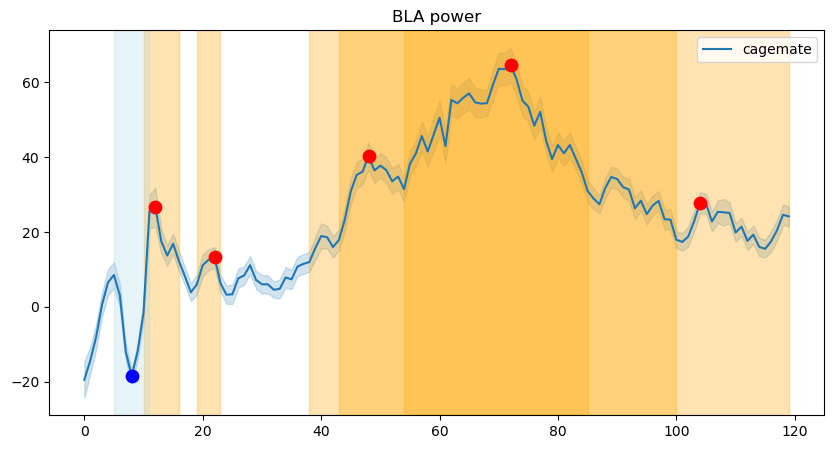

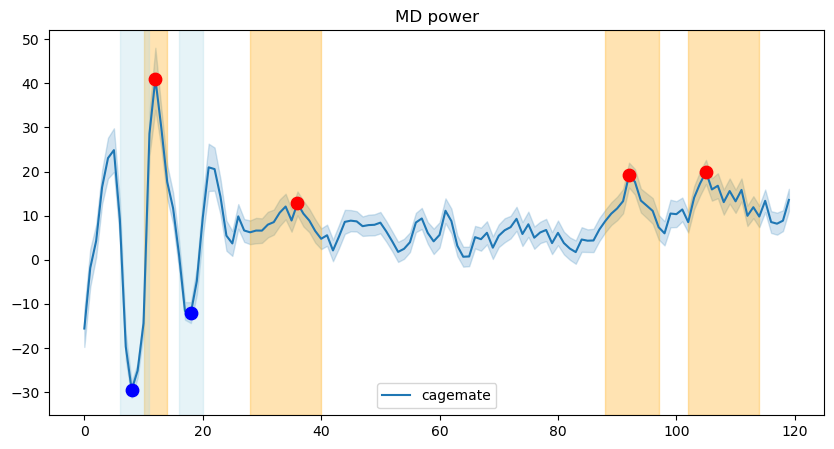

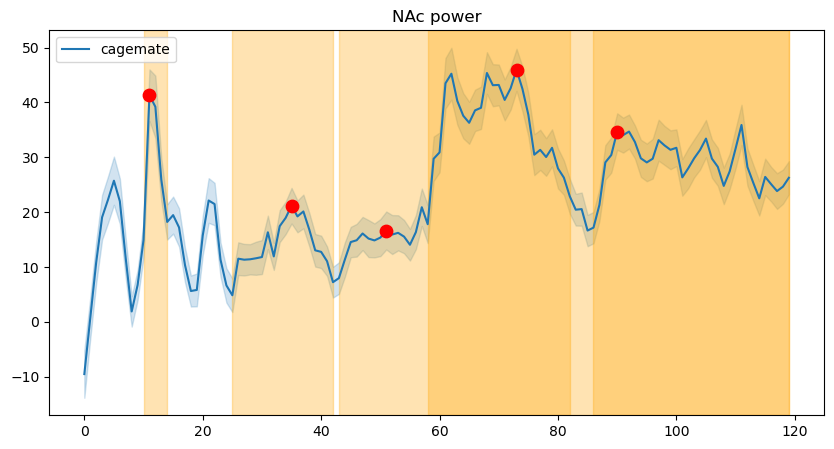

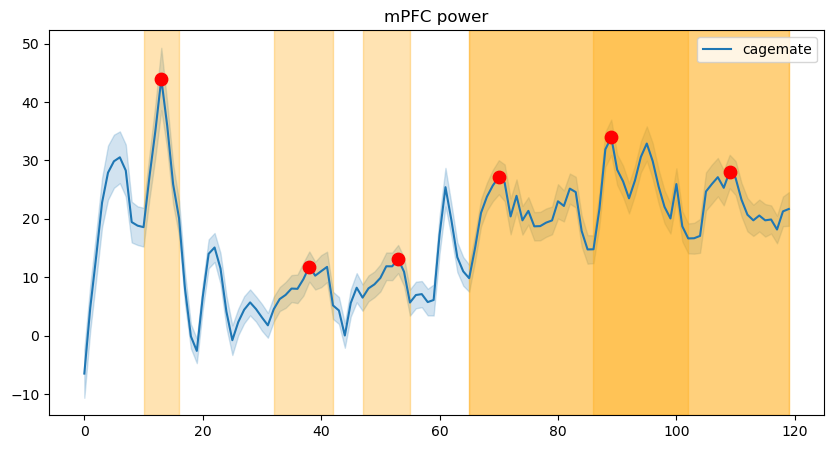

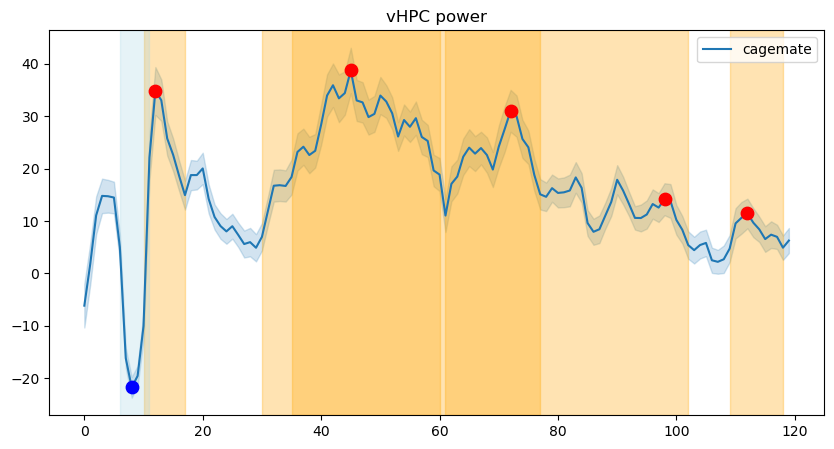

/scratch/local/64062145/ipykernel_2938468/2993160671.py:276: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(np.array(averages), axis=0)
/scratch/local/64062145/ipykernel_2938468/2993160671.py:279: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  event_sem = stats.sem(averages, axis=0, nan_policy="omit")


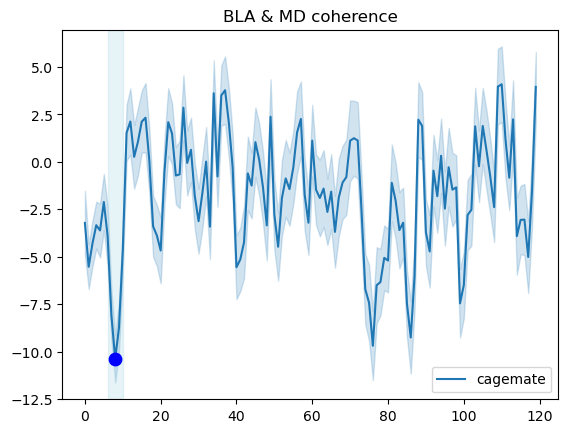

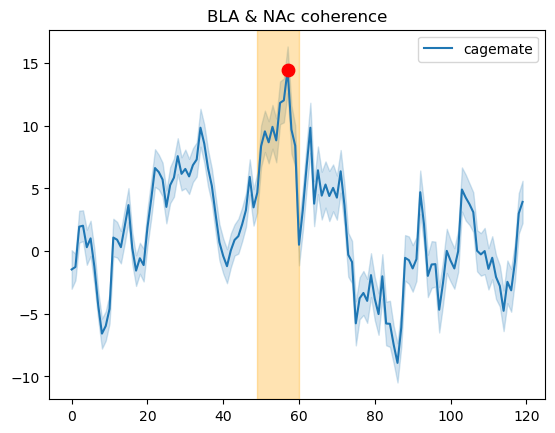

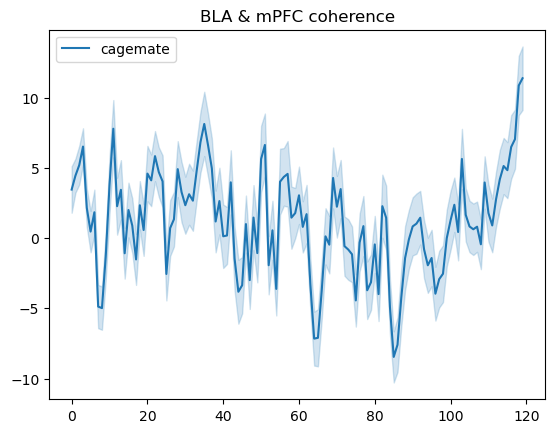

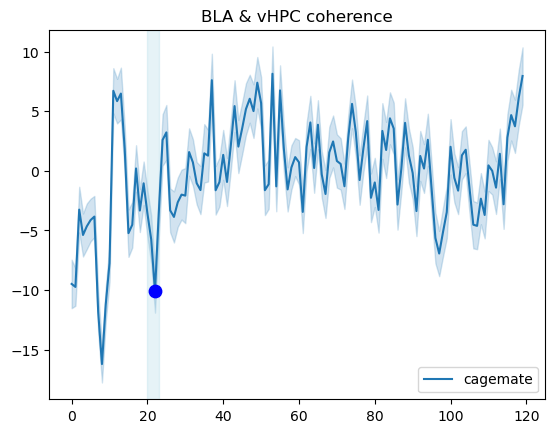

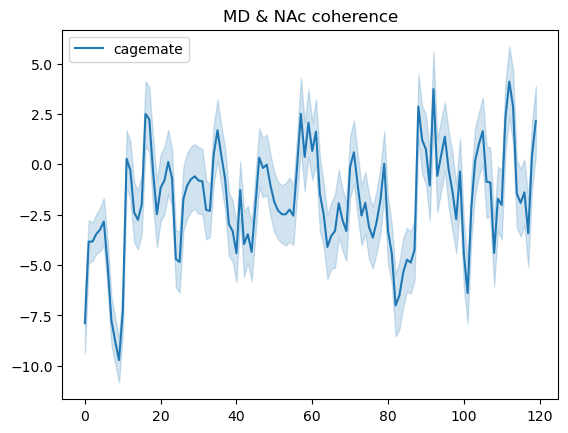

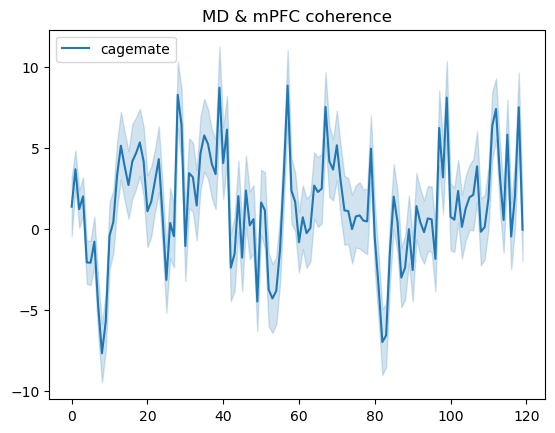

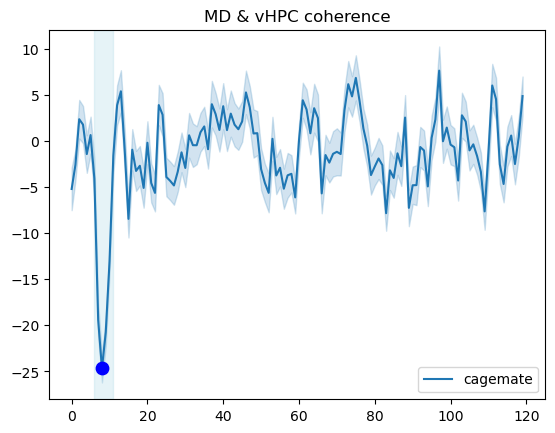

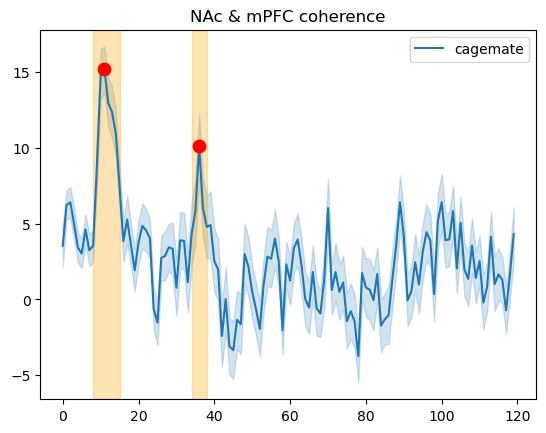

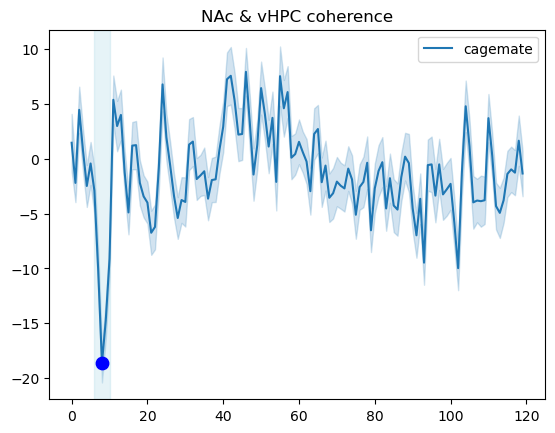

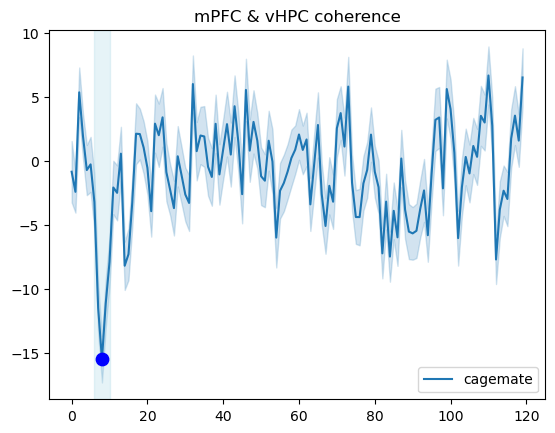

/scratch/local/64062145/ipykernel_2938468/2993160671.py:371: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(np.array(averages), axis=0)
/scratch/local/64062145/ipykernel_2938468/2993160671.py:374: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  event_sem = stats.sem(averages, axis=0, nan_policy="omit")


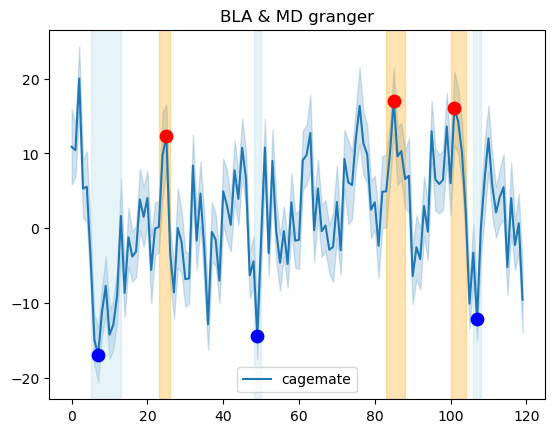

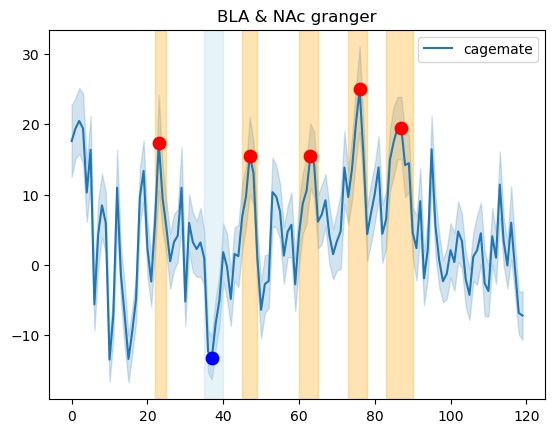

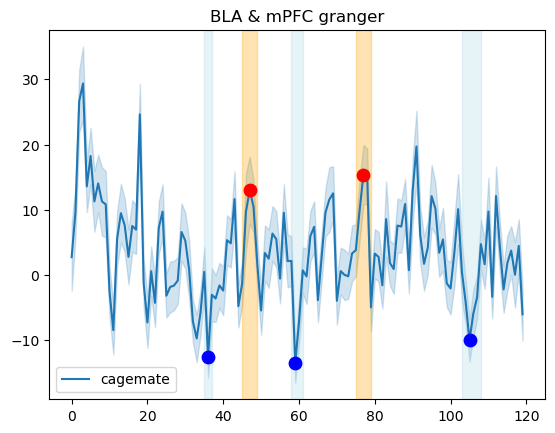

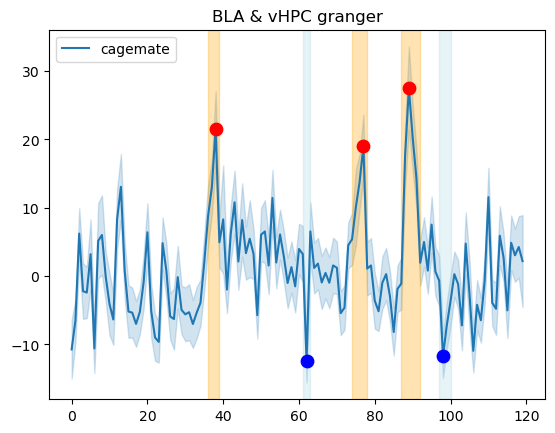

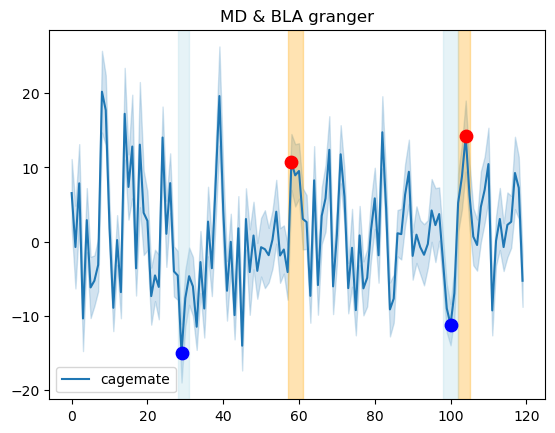

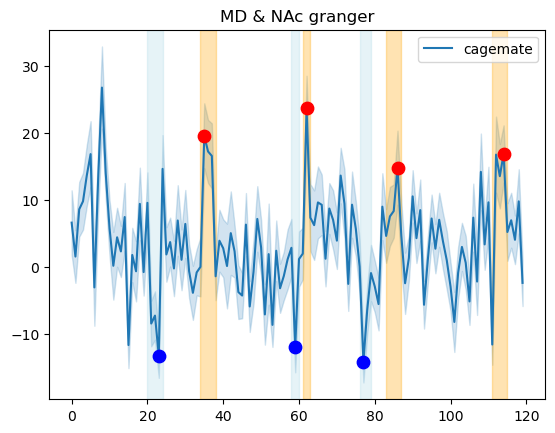

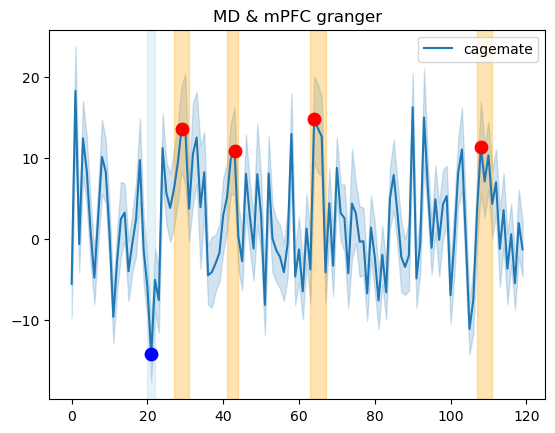

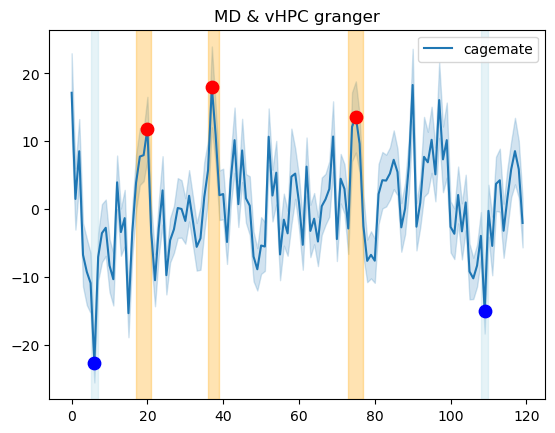

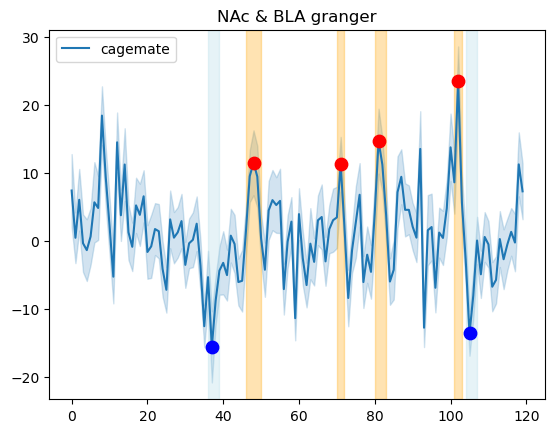

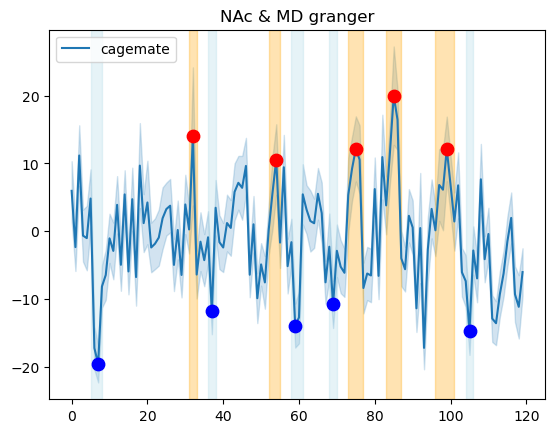

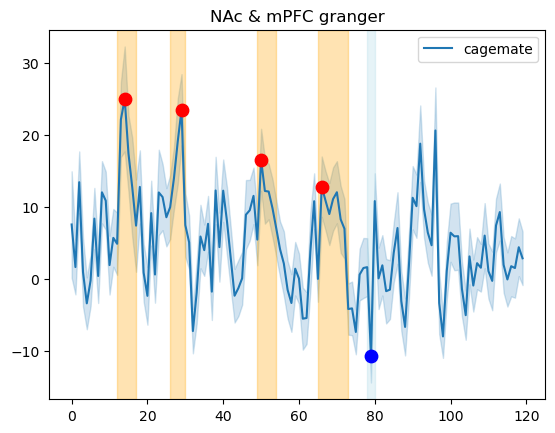

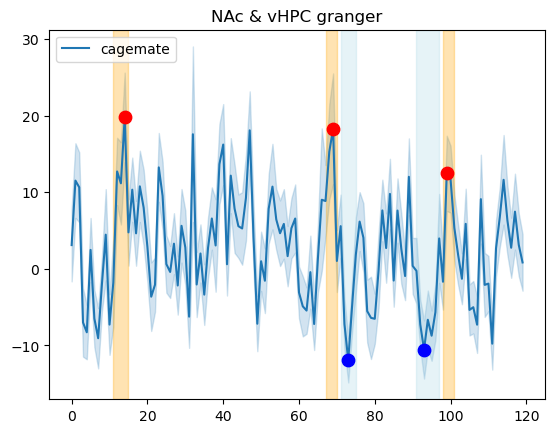

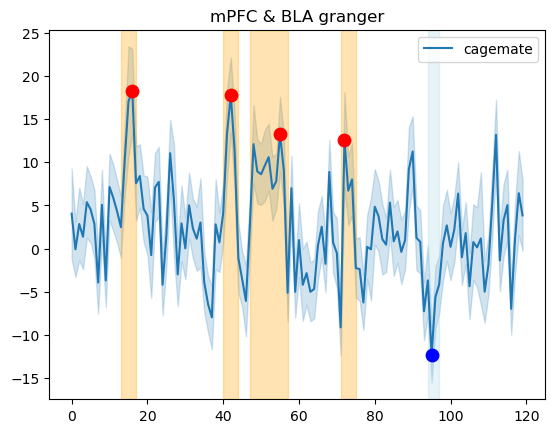

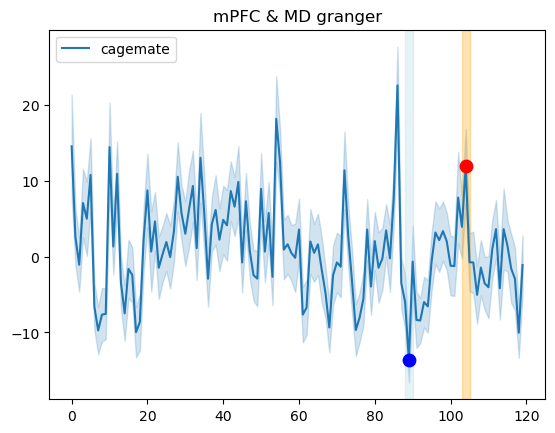

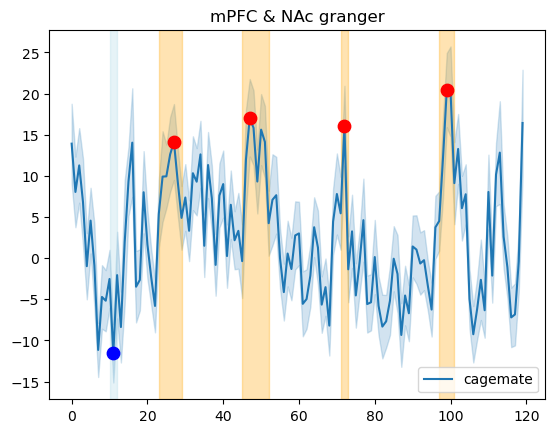

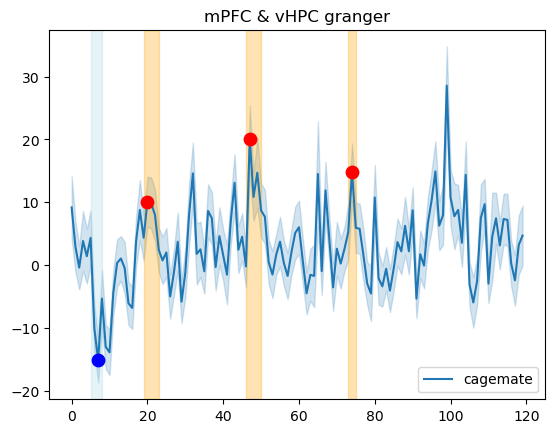

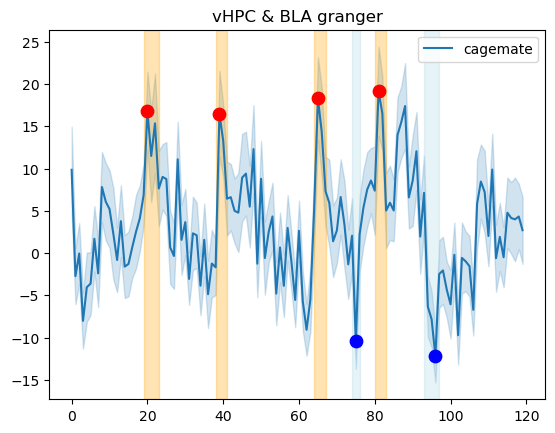

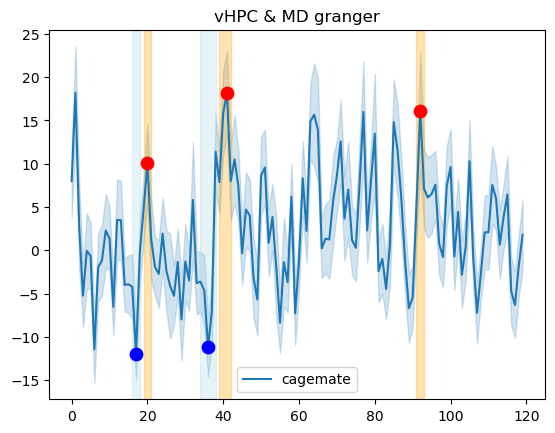

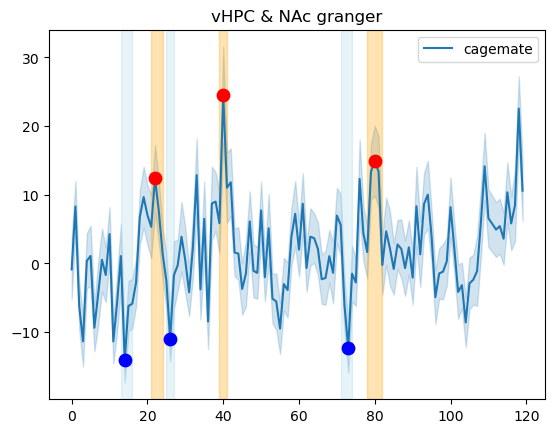

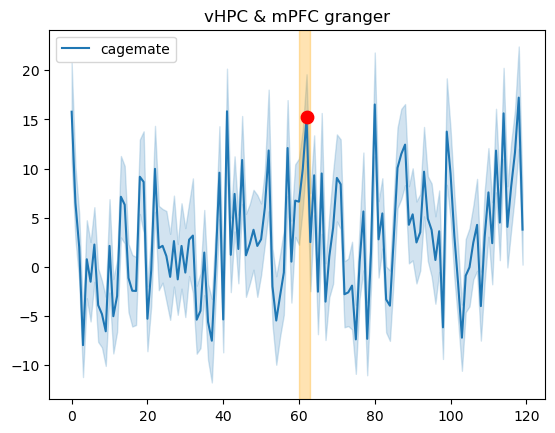

In [8]:
diff = lfpa.average_events(cups_collection, events = ['cagemate'], baseline = 'cagemate_baseline', mode = 'power', plot=False)
coh_diff = lfpa.average_events(cups_collection, events = ['cagemate'], baseline = 'cagemate_baseline', mode = 'coherence', plot=False)
grang_diff = lfpa.average_events(cups_collection,events = ['cagemate'], baseline = 'cagemate_baseline', mode = 'granger', plot=False)

peak_height = 10
distance = 10
peak_width = 3
threshold_percent = 50

power_ranges = plot_power_averages(cups_collection, diff, freq_range = (0,120), peak_height= peak_height, peak_width = peak_width, distance = distance, threshold_percent=threshold_percent)
coherence_ranges = plot_coherence_averages(cups_collection, coh_diff, freq_range = (0,120), peak_height= peak_height, peak_width = peak_width, distance = distance,  threshold_percent = threshold_percent)
granger_ranges = plot_granger_averages(cups_collection, grang_diff, freq_range = (0,120), peak_height= peak_height, peak_width = peak_width, distance = distance, threshold_percent = threshold_percent)


In [9]:
total_power_features = 0
total_granger_features = 0
total_coherence_features = 0 
for i in range(len(power_ranges)):
    total_power_features += len(power_ranges[i])
for i in range(len(coherence_ranges)):
    total_coherence_features += len(coherence_ranges[i])
for i in range(len(granger_ranges)):
    total_granger_features += len(granger_ranges[i])
    
print(total_power_features, total_coherence_features, total_granger_features)
    

29 25 25


In [11]:
from importlib import reload
import itertools
reload(lfpa)
regions_bidict = cups_collection.brain_region_dict
averages = {}
events = ['cagemate','novel', 'familiar']
baselines = ['cagemate_baseline', 'novel_baseline', 'familiar_baseline']
          
for recording in cups_collection.lfp_recordings: 
    averages[recording.subject] ={}
    for mode in ['power', 'coherence', 'granger']:
        regions = list(regions_bidict.keys())
        event_avg_dict = lfpa.average_events(recording, events = events, baseline = baselines, mode = mode)
        for event in event_avg_dict.keys():
            if mode == 'power':
                for i in range(len(power_ranges)):
                    for j in range(len(power_ranges[i])):
                        freq_range = power_ranges[i][j]
                        region = regions_bidict.inverse[i]
                        event_array = np.array(event_avg_dict[event])
                        values = event_array[:,freq_range[0]:freq_range[1],i]
                        average_val = np.nanmean(values, axis = 0)
                        averages[recording.subject][f"{event}_{freq_range[0]}_{freq_range[1]}_{region}_power"] = np.nanmean(values)
            # For coherence (2D symmetric matrix) - use combinations
            elif mode == 'coherence':
                # itertools.combinations gives all unique pairs (no repetition, order doesn't matter)
                for i in range(len(coherence_ranges)):
                    for j in range(len(coherence_ranges[i])):
                        for k in range(len(coherence_ranges[i][j])):
                            freq_range = coherence_ranges[i][j][k]
                            region1 = regions_bidict.inverse[i]
                            region2 = regions_bidict.inverse[j]
                            event_array = np.array(event_avg_dict[event])
                            values = event_array[:,freq_range[0]:freq_range[1],i,j]
                            average_val = np.nanmean(values, axis = 0)
                            averages[recording.subject][f"{event}_{freq_range[0]}_{freq_range[1]}_{region1}_{region2}_coherence"] = np.nanmean(values)

#             # For Granger (2D directed matrix) - use permutations
            elif mode == 'granger':
                # itertools.permutations gives all ordered pairs (direction matters)
               for i in range(len(granger_ranges)):
                    for j in range(len(granger_ranges[i])):
                        for k in range(len(granger_ranges[i][j])):
                            freq_range = granger_ranges[i][j][k]
                            region1 = regions_bidict.inverse[i]
                            region2 = regions_bidict.inverse[j]
                            event_array = np.array(event_avg_dict[event])
                            values = event_array[:,freq_range[0]:freq_range[1],i,j]
                            average_val = np.nanmean(values, axis = 0)
                            averages[recording.subject][f"{event}_{freq_range[0]}_{freq_range[1]}_{region1}_to_{region2}_granger"] = np.nanmean(values)
lfp_df = pd.DataFrame.from_dict(averages, orient = 'index')
lfp_df

cagemate_10_16_mPFC_power  cagemate_19_23_mPFC_power  \
2.4                  37.925395                   8.991804   
2.3                  17.736895                   6.858863   
2.1                  55.295405                  32.310354   
3.1                  55.986967                   4.771487   
1.1                  46.154521                  10.401230   
1.3                  17.128365                  -3.177682   
4.4                  38.347225                  11.778819   
2.2                  18.340335                   9.072224   
3.2                 -11.792099                 -28.211090   
4.1                  38.459303                  -0.508170   

     cagemate_43_100_mPFC_power  cagemate_54_85_mPFC_power  \
2.4                   15.552170                  14.815628   
2.3                    8.353146                  11.760271   
2.1                   16.954493                  16.768089   
3.1                   15.421718                  12.098450   
1.1                   30.096325                  31.437744   
1.3                    9.033120                  11.451418   
4.4                   30.033161                  32.868774   
2.2                   13.543412                  12.136847   
3.2                   20.376266                  15.303702   
4.1                   27.498261                  25.006820   

     cagemate_38_119_mPFC_power  cagemate_5_11_mPFC_power  \
2.4                   14.979706                  2.655591   
2.3                    8.314637                  6.231423   
2.1                   18.377784                 31.762173   
3.1                   13.617454                 37.182779   
1.1                   32.603392                108.452931   
1.3                    7.824015                 18.807941   
4.4                   32.945511                -14.859517   
2.2                   13.360066                 37.465194   
3.2                   24.672463                 14.838055   
4.1                   25.463303                  8.469014   

     cagemate_10_14_NAc_power  cagemate_28_40_NAc_power  \
2.4                  9.801750                -46.590758   
2.3                 -3.614795                  7.189285   
2.1                102.079029                 52.323876   
3.1                 29.149385                 21.885202   
1.1                 38.980489                 17.431227   
1.3                 21.545801                  6.850450   
4.4                 50.965562                 24.563832   
2.2                 20.243175                 31.326581   
3.2                 11.357617                -15.235673   
4.1                -12.334524                  5.301011   

     cagemate_88_97_NAc_power  cagemate_102_114_NAc_power  ...  \
2.4                -45.023657                  -34.332727  ...   
2.3                 29.574551                   10.605847  ...   
2.1                 53.854437                   46.112217  ...   
3.1                  6.912652                    2.840106  ...   
1.1                 45.904912                   63.937380  ...   
1.3                 47.632188                   25.901813  ...   
4.4                 66.221338                   72.791369  ...   
2.2                 16.694397                   13.177379  ...   
3.2                 51.093552                   61.662133  ...   
4.1                 27.351307                   34.086776  ...   

     familiar_39_42_vHPC_to_MD_granger  familiar_91_93_vHPC_to_MD_granger  \
2.4                           6.329233                         -16.277050   
2.3                         -29.890027                          24.024024   
2.1                          -2.749224                         -16.690554   
3.1                         -17.605935                          16.274191   
1.1                         -27.697042                           9.597681   
1.3                         -29.225900                          -9.982653   
4.4                          15.271672                        

In [12]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest
event_iwant = ['cagemate','familiar','novel','empty']
event_info = {}
sniff_itis = []
j = 0
total_sniffs = 0
subject_info = {}

for recording in cups_collection.lfp_recordings:
    subject = recording.subject
    for event, events in recording.behavior_dict.items():
        if event in event_iwant:
            no_events = events.shape[0]
            sniff_length = 0
            for i in range(len(events)):
                sniff_length_temp = events[i][1] - events[i][0]
                sniff_length = sniff_length + sniff_length_temp
                total_sniffs = total_sniffs + 1
                try:
                    sniff_iti = events[i+1][0] - events[i][1]
                    sniff_itis.append(sniff_iti)
                except IndexError:
                    pass
            total_sniff_time = sniff_length/1000
            try:
                avg_event = sniff_length/no_events/1000
            except ZeroDivisionError:
                avg_event = 0
            if subject in event_info.keys():
                dict_event = event_info[subject]
                dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
                event_info[subject] =  dict_event
            else:
                event_info[subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
            j += 1
        else:
            pass
event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()

event_overview

event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_total_time['total cup time'] = event_total_time['familiar'] + event_total_time['novel'] + event_total_time['cagemate'] + event_total_time['empty']
event_total_time['cagemate preference']= event_total_time['cagemate'] / event_total_time['total cup time']
event_total_time['familiar preference'] =event_total_time['familiar'] / event_total_time['total cup time']
event_total_time['novel preference'] =event_total_time['novel'] / event_total_time['total cup time']
event_total_time['empty prefernce']= event_total_time['empty'] / event_total_time['total cup time']
event_total_time.index = event_total_time['level_0']
event_total_time = event_total_time.drop(['level_0', 'level_1'], axis = 1)
event_total_time

/scratch/local/64062145/ipykernel_2938468/2648196768.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_total_time['total cup time'] = event_total_time['familiar'] + event_total_time['novel'] + event_total_time['cagemate'] + event_total_time['empty']
/scratch/local/64062145/ipykernel_2938468/2648196768.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_total_time['cagemate preference']= event_total_time['cagemate'] / event_total_time['total cup time']
/scratch/local/64062145/ipykernel_293846

familiar    novel  cagemate   empty  total cup time  \
level_0                                                        
2.4        36.668  154.866    36.335   5.266         233.135   
2.3       130.797  140.200   122.191  96.397         489.585   
2.1        16.330   55.867   353.388  69.266         494.851   
3.1        77.932  188.134    28.734  24.599         319.399   
1.1         7.400  120.868   102.267  42.865         273.400   
1.3        25.265   61.466   105.463  98.132         290.326   
4.4         6.665   19.332   512.987   6.332         545.316   
2.2        15.134   35.533   447.237  26.999         524.903   
3.2         9.665   71.333    87.866   1.066         169.930   
4.1        40.926   56.994   128.925  55.863         282.708   

         cagemate preference  familiar preference  novel preference  \
level_0                                                               
2.4                 0.155854             0.157282          0.664276   
2.3                 0.249581             0.267159          0.286365   
2.1                 0.714130             0.033000          0.112897   
3.1                 0.089963             0.243996          0.589025   
1.1                 0.374056             0.027067          0.442092   
1.3                 0.363257             0.087023          0.211714   
4.4                 0.940715             0.012222          0.035451   
2.2                 0.852037             0.028832          0.067694   
3.2                 0.517072             0.056876          0.419779   
4.1                 0.456036             0.144764          0.201600   

         empty prefernce  
level_0                   
2.4             0.022588  
2.3             0.196895  
2.1             0.139973  
3.1             0.077017  
1.1             0.156785  
1.3             0.338006  
4.4             0.011612  
2.2             0.051436  
3.2             0.006273  
4.1             0.197600

Feature  cagemate preference  novel preference
0       novel_67_70_NAc_to_vHPC_granger             0.346786          0.069683
1              familiar_5_11_mPFC_power             0.343016          0.215516
2         novel_58_61_NAc_to_MD_granger             0.305397          0.042063
3    cagemate_78_80_NAc_to_mPFC_granger             0.283849          0.000000
4    cagemate_13_16_vHPC_to_NAc_granger             0.273968          0.000000
..                                  ...                  ...               ...
412     novel_71_73_mPFC_to_NAc_granger             0.000000          0.000000
413     novel_10_12_mPFC_to_NAc_granger             0.000000          0.000000
414    novel_103_105_mPFC_to_MD_granger             0.000000          0.000000
415     novel_13_17_mPFC_to_BLA_granger             0.000000          0.000000
416     novel_65_73_NAc_to_mPFC_granger             0.000000          0.000000

[417 rows x 3 columns]

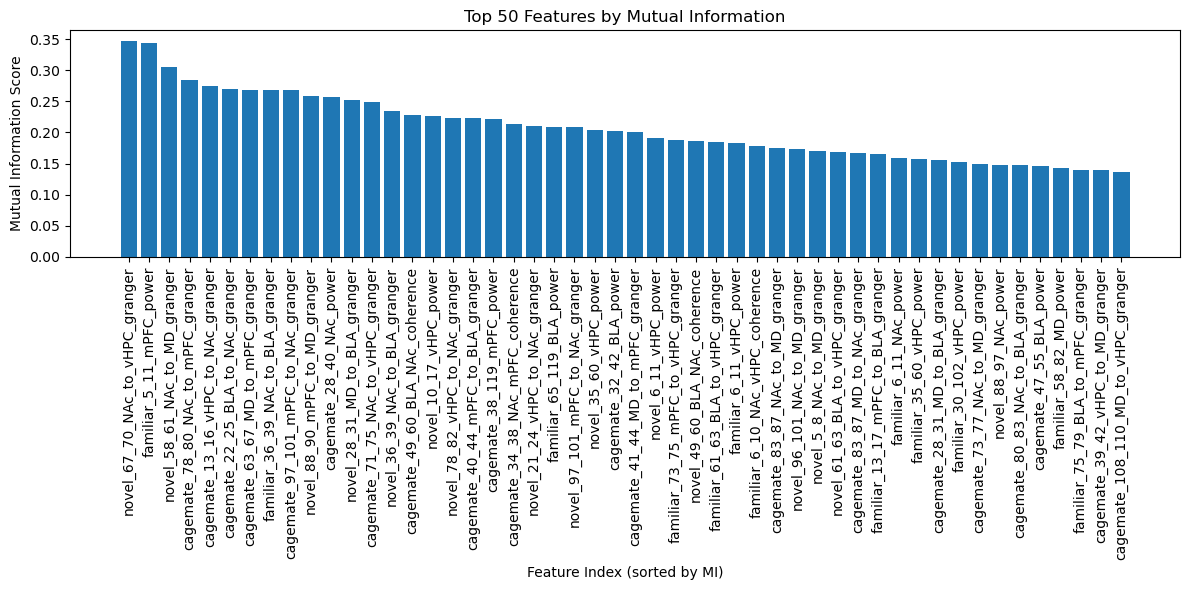

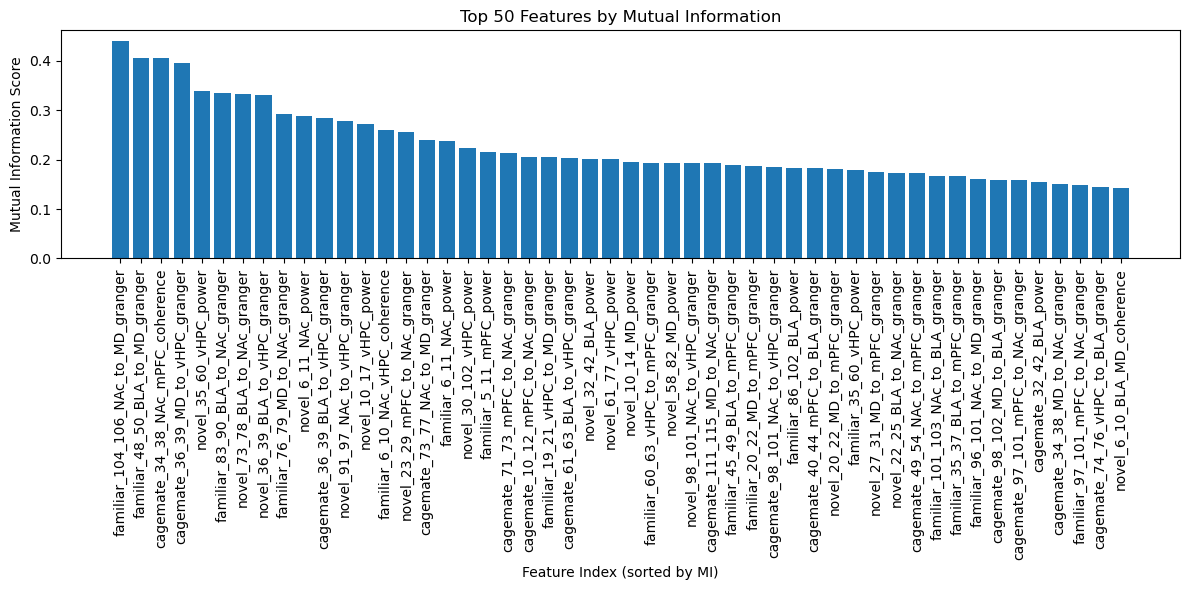

In [20]:


# Assume X contains your 500+ neural features and y is behavioral outcome
# X shape: (n_samples, n_features)
# y shape: (n_samples,)
X = lfp_df 
all_mi_results = pd.DataFrame()
for column_name in ['cagemate preference', 'novel preference']:
    y = event_total_time[column_name]
    # Calculate mutual information between each feature and target
    mi_scores = mutual_info_regression(X, y)
    mi_df = pd.DataFrame({'Feature': X.columns, 
                              column_name: mi_scores})
    mi_df = mi_df.sort_values(column_name, ascending=False).reset_index(drop=True)
    if not all_mi_results.empty:
    # Create DataFrame for better analysis
        all_mi_results = pd.merge(all_mi_results, mi_df, on='Feature')
    else:
        all_mi_results= mi_df
        
    # Visualize MI scores
    plt.figure(figsize=(12, 6))
    plt.bar(mi_df['Feature'][:50], mi_df[column_name][:50])  # Top 50 features
    plt.xlabel('Feature Index (sorted by MI)')
    plt.xticks(rotation = 90)
    plt.ylabel('Mutual Information Score')
    plt.title('Top 50 Features by Mutual Information')
    plt.tight_layout()

all_mi_results


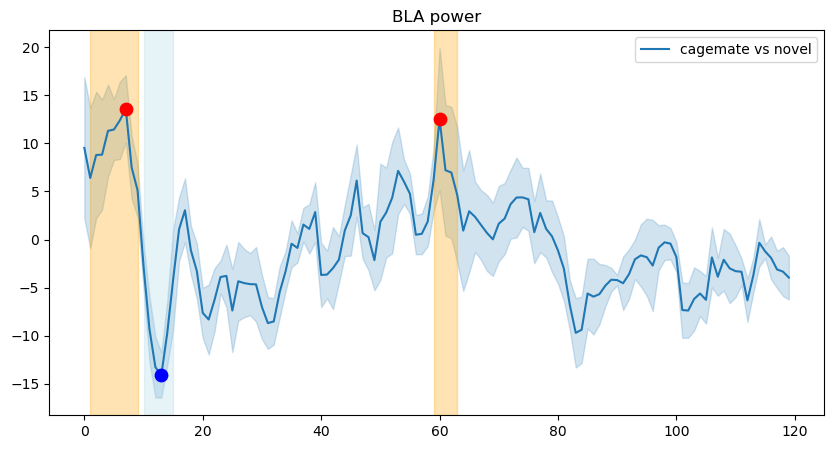

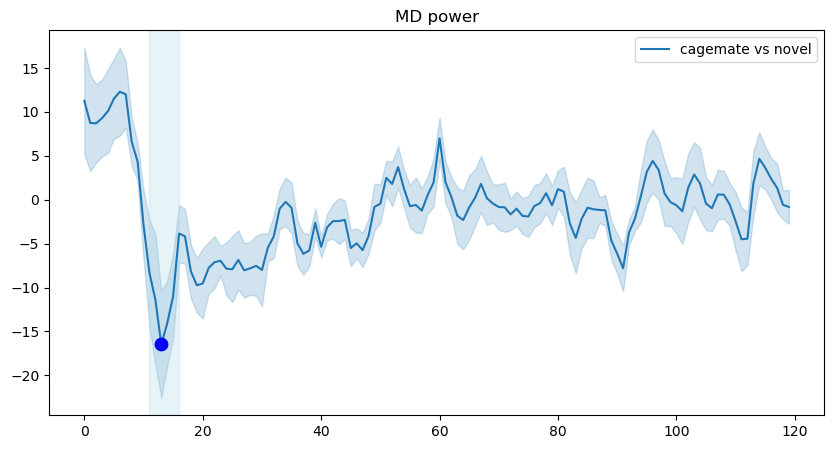

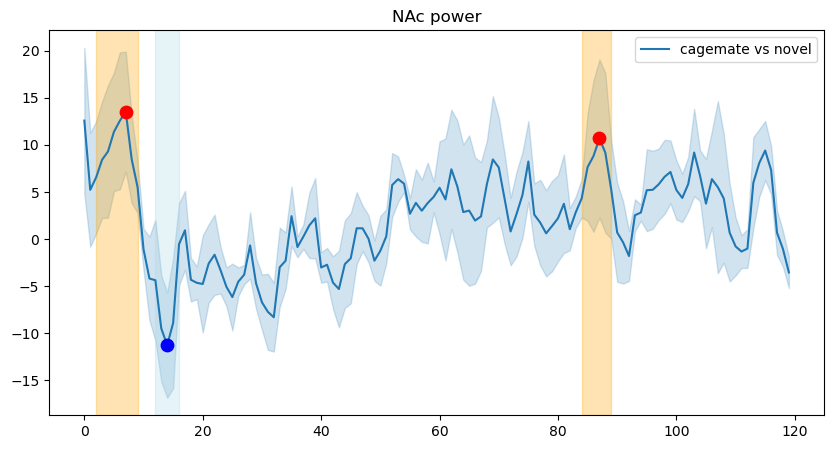

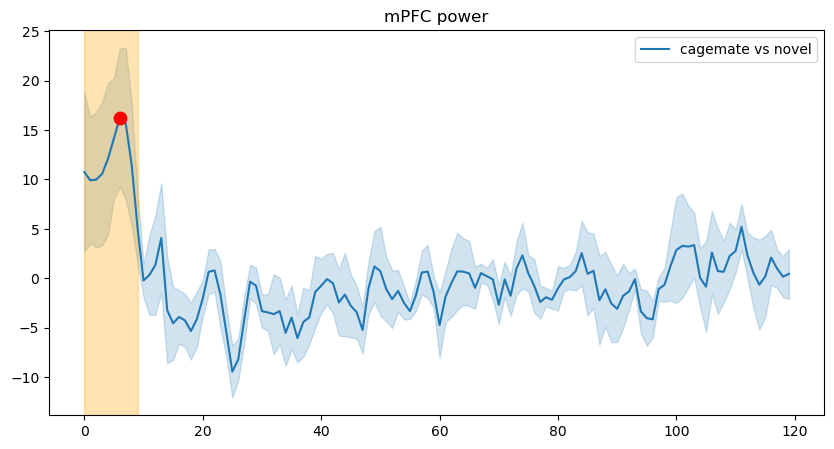

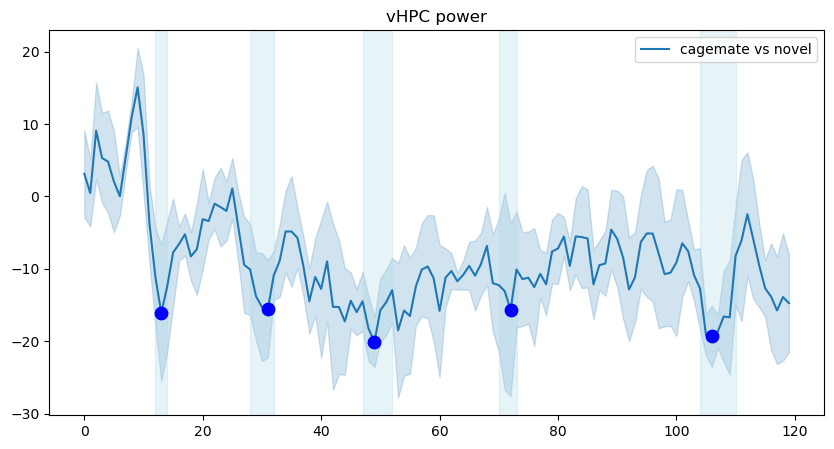

/scratch/local/64062145/ipykernel_2938468/2993160671.py:276: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(np.array(averages), axis=0)
/scratch/local/64062145/ipykernel_2938468/2993160671.py:279: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  event_sem = stats.sem(averages, axis=0, nan_policy="omit")


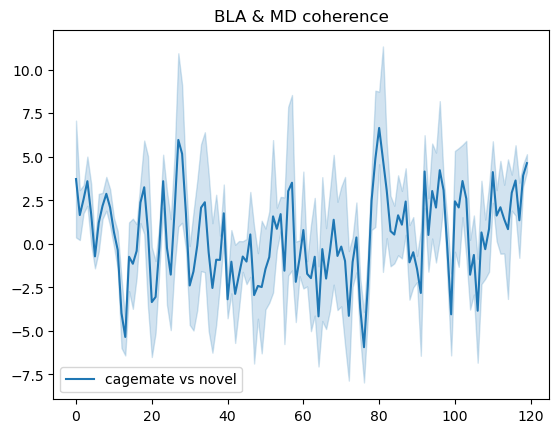

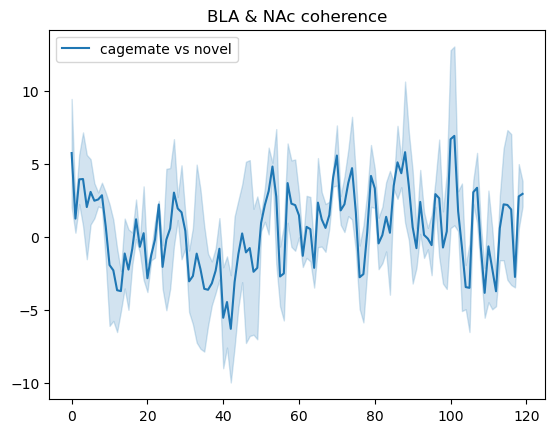

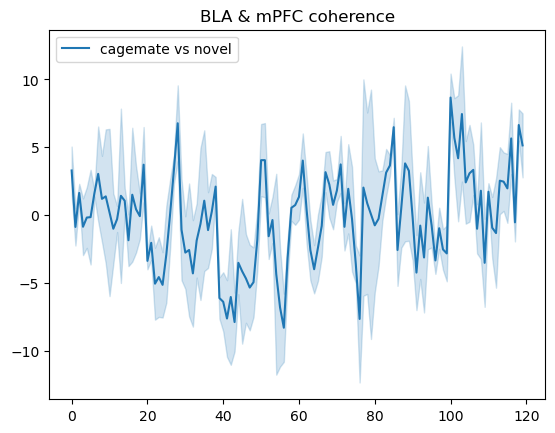

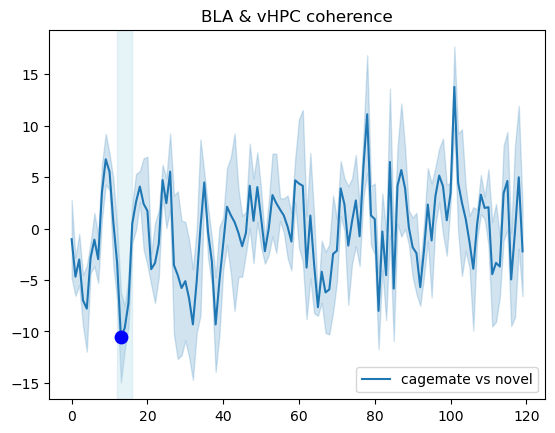

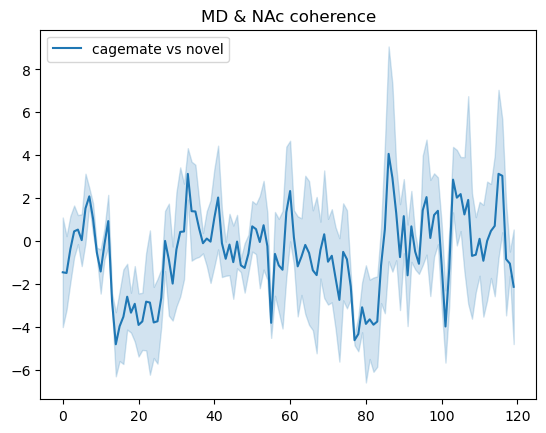

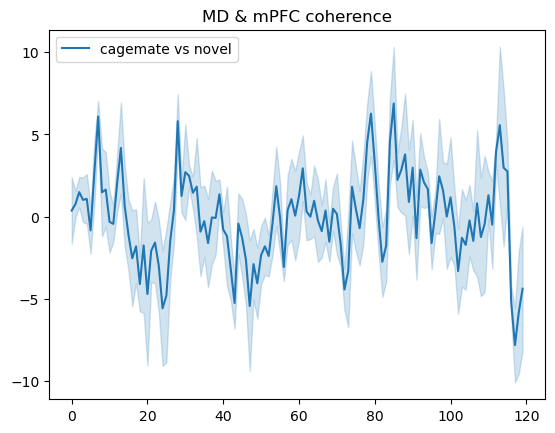

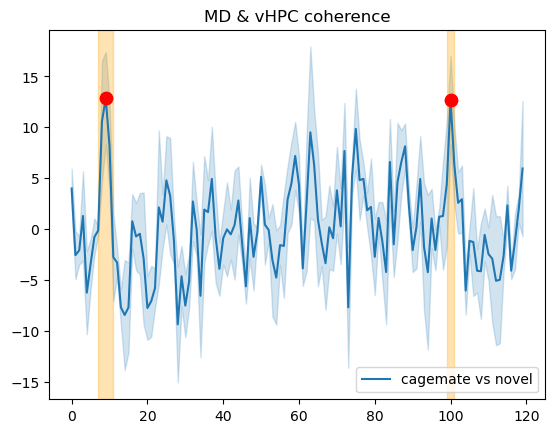

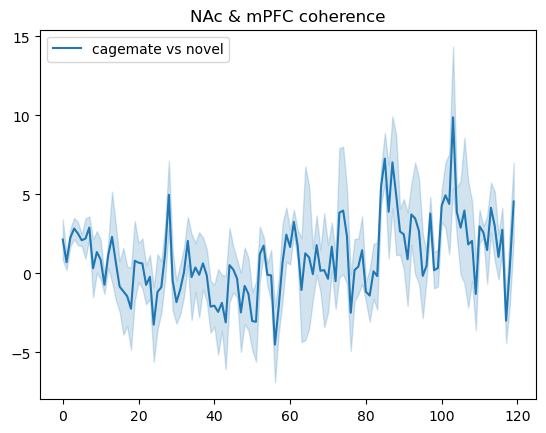

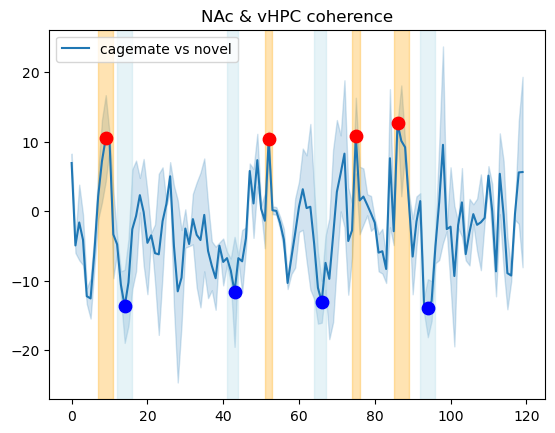

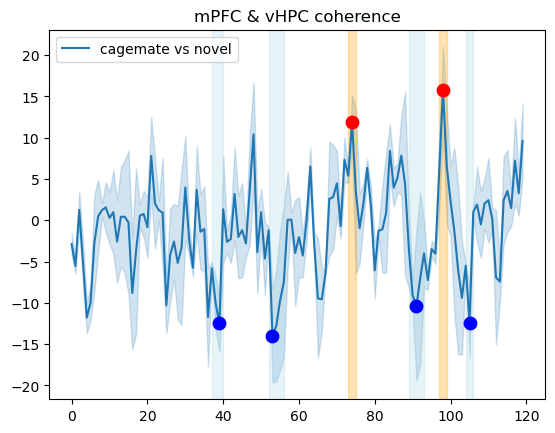

/scratch/local/64062145/ipykernel_2938468/2993160671.py:371: RuntimeWarning: Mean of empty slice
  event_average = np.nanmean(np.array(averages), axis=0)
/scratch/local/64062145/ipykernel_2938468/2993160671.py:374: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  event_sem = stats.sem(averages, axis=0, nan_policy="omit")


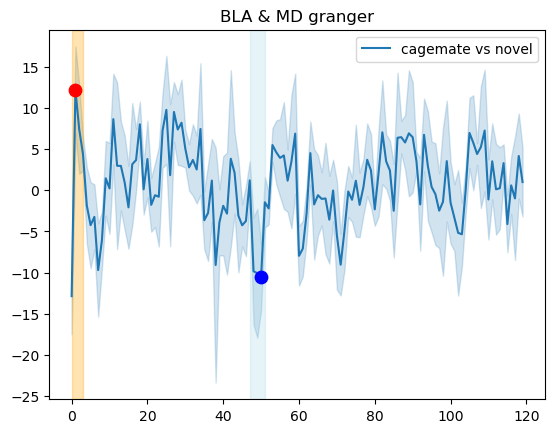

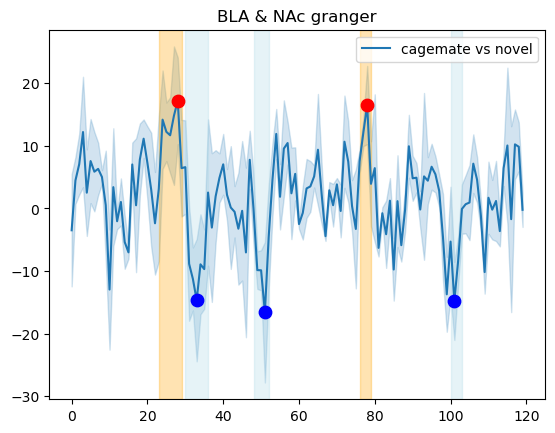

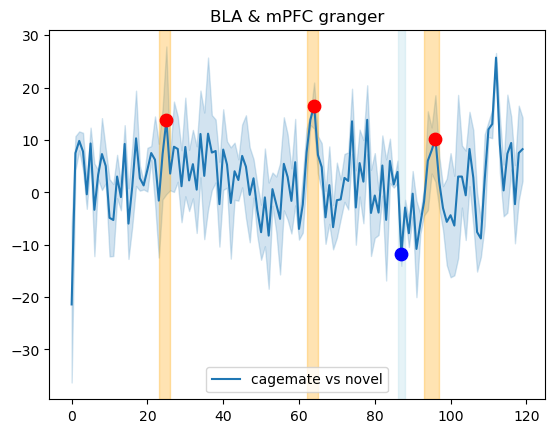

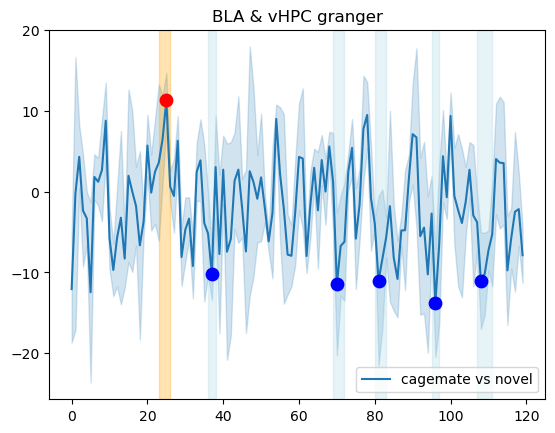

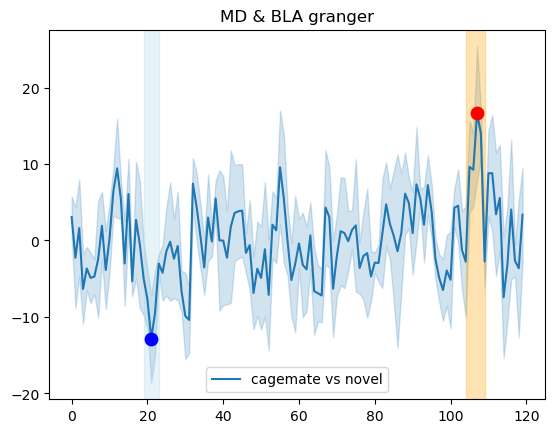

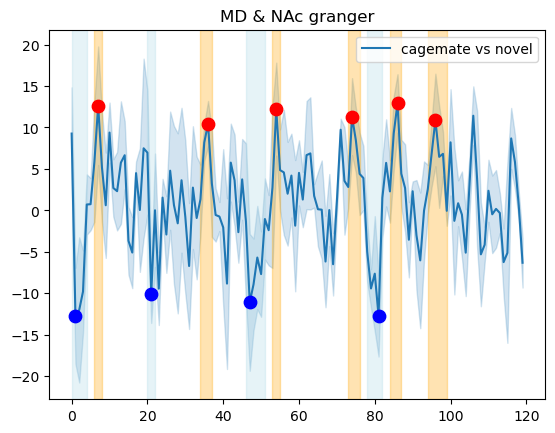

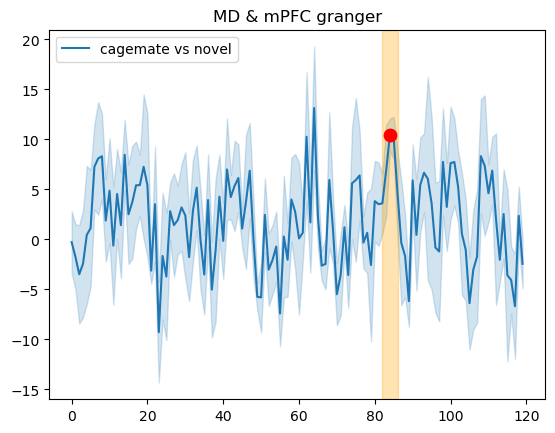

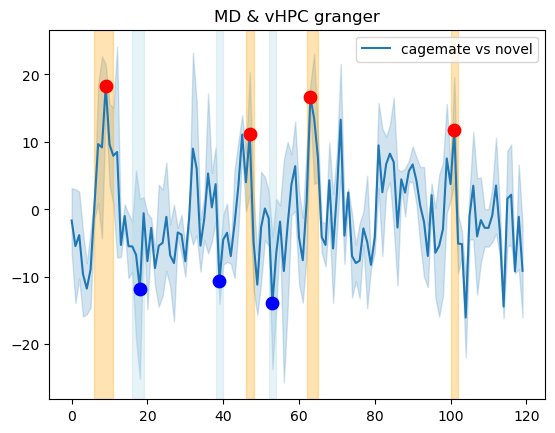

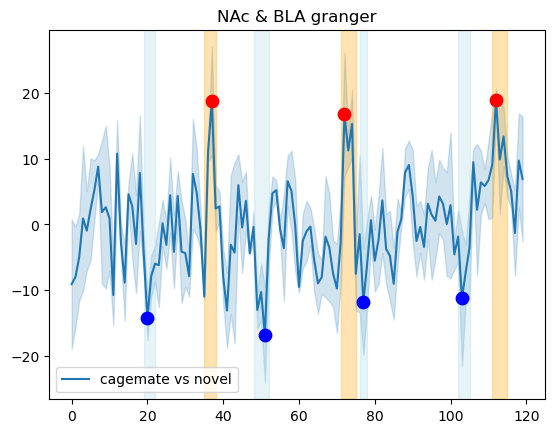

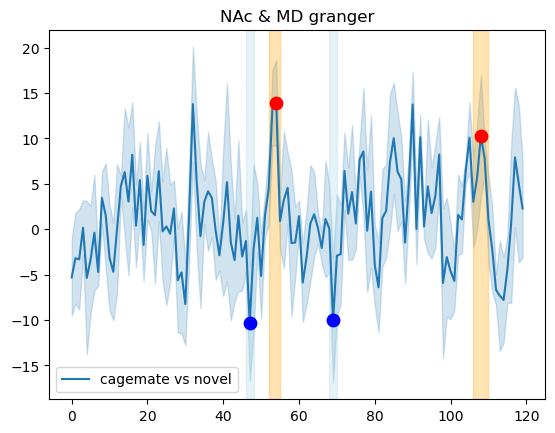

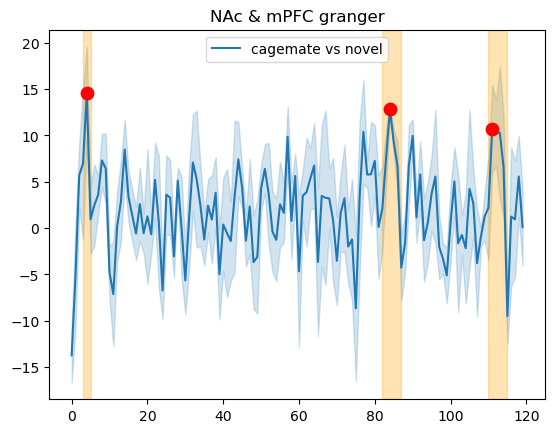

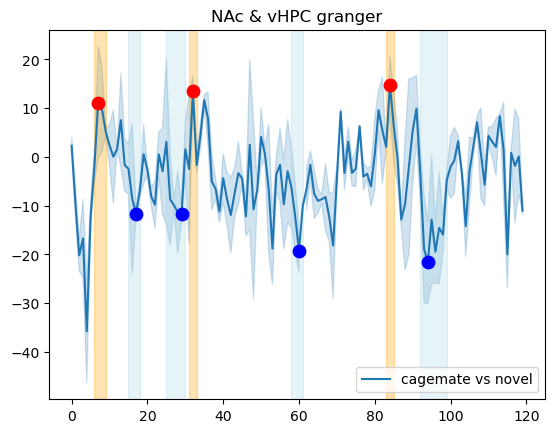

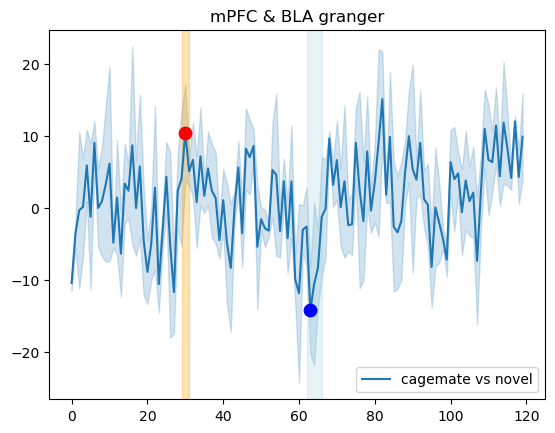

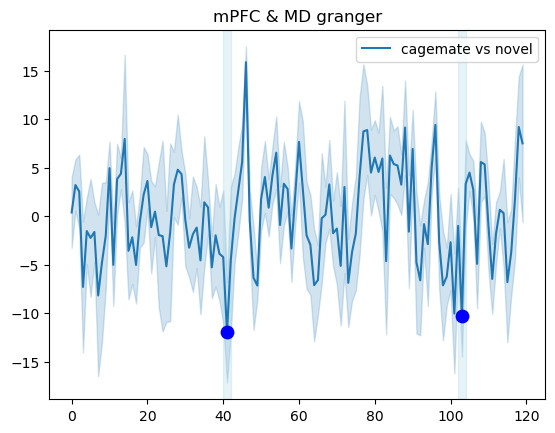

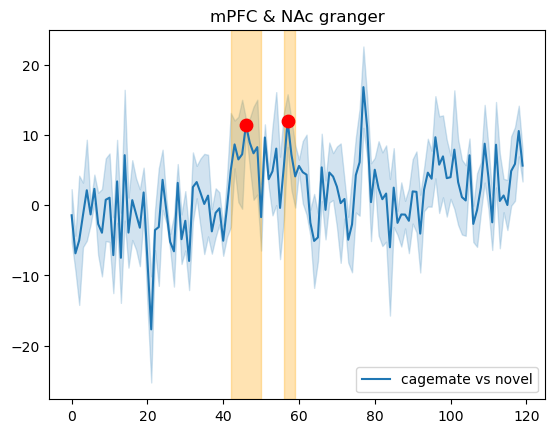

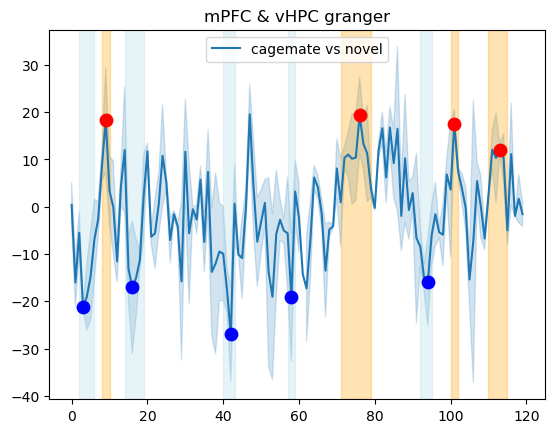

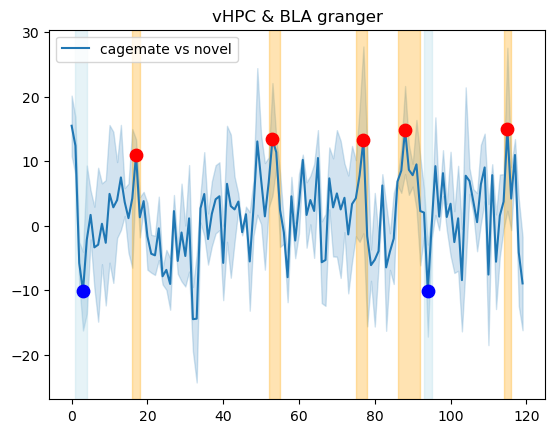

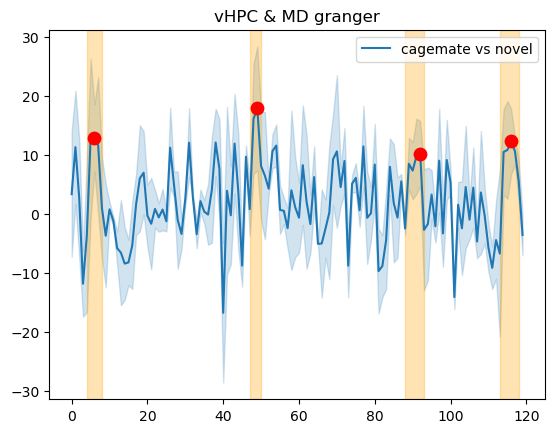

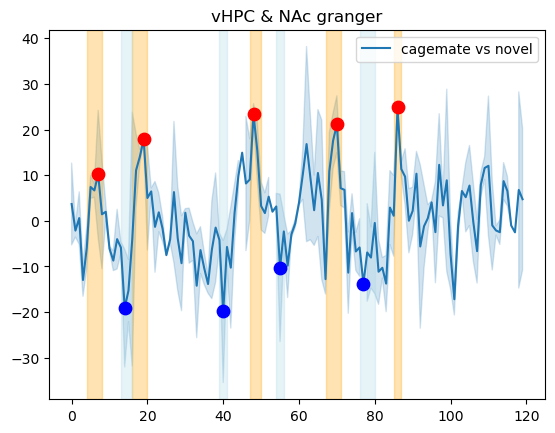

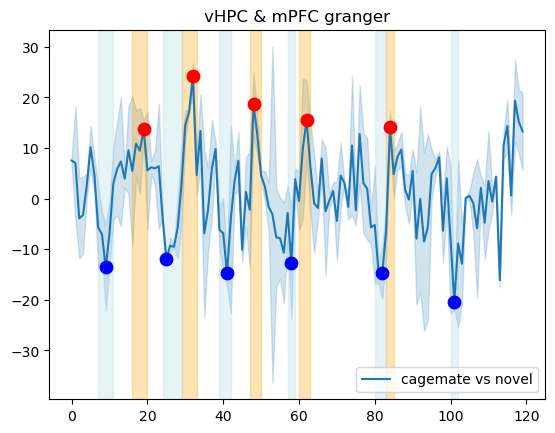

In [23]:
diff = lfpa.event_difference(cups_collection, event1 = 'cagemate', event2 = 'novel', mode = 'power', plot=False)
coh_diff = lfpa.event_difference(cups_collection, event1 = 'cagemate', event2 = 'novel', mode = 'coherence', plot=False)
grang_diff = lfpa.event_difference(cups_collection,event1 = 'cagemate', event2 = 'novel', mode = 'granger', plot=False)

peak_height = 10
distance = 10
peak_width = 3
threshold_percent = 50

power_ranges = plot_power_averages(cups_collection, diff, freq_range = (0,120), peak_height= peak_height, peak_width = peak_width, distance = distance, threshold_percent=threshold_percent)
coherence_ranges = plot_coherence_averages(cups_collection, coh_diff, freq_range = (0,120), peak_height= peak_height, peak_width = peak_width, distance = distance,  threshold_percent = threshold_percent)
granger_ranges = plot_granger_averages(cups_collection, grang_diff, freq_range = (0,120), peak_height= peak_height, peak_width = peak_width, distance = distance, threshold_percent = threshold_percent)

In [25]:
total_power_features = 0
total_granger_features = 0
total_coherence_features = 0 
for i in range(len(power_ranges)):
    total_power_features += len(power_ranges[i])
for i in range(len(coherence_ranges)):
    total_coherence_features += len(coherence_ranges[i])
for i in range(len(granger_ranges)):
    total_granger_features += len(granger_ranges[i])
    
print(total_power_features, total_coherence_features, total_granger_features)
    

13 25 25


In [28]:
from importlib import reload
import itertools
reload(lfpa)
regions_bidict = cups_collection.brain_region_dict
averages = {}
events = ['cagemate','novel']
baselines = ['cagemate_baseline', 'novel_baseline']
          
for recording in cups_collection.lfp_recordings: 
    averages[recording.subject] ={}
    for mode in ['power', 'coherence', 'granger']:
        regions = list(regions_bidict.keys())
        event_avg_dict = lfpa.average_events(recording, events = events, baseline = baselines, mode = mode)
        for event in event_avg_dict.keys():
            if mode == 'power':
                for i in range(len(power_ranges)):
                    for j in range(len(power_ranges[i])):
                        freq_range = power_ranges[i][j]
                        region = regions_bidict.inverse[i]
                        event_array = np.array(event_avg_dict[event])
                        values = event_array[:,freq_range[0]:freq_range[1],i]
                        average_val = np.nanmean(values, axis = 0)
                        averages[recording.subject][f"{event}_{freq_range[0]}_{freq_range[1]}_{region}_power"] = np.nanmean(values)
            # For coherence (2D symmetric matrix) - use combinations
            elif mode == 'coherence':
                # itertools.combinations gives all unique pairs (no repetition, order doesn't matter)
                for i in range(len(coherence_ranges)):
                    for j in range(len(coherence_ranges[i])):
                        for k in range(len(coherence_ranges[i][j])):
                            freq_range = coherence_ranges[i][j][k]
                            region1 = regions_bidict.inverse[i]
                            region2 = regions_bidict.inverse[j]
                            event_array = np.array(event_avg_dict[event])
                            values = event_array[:,freq_range[0]:freq_range[1],i,j]
                            average_val = np.nanmean(values, axis = 0)
                            averages[recording.subject][f"{event}_{freq_range[0]}_{freq_range[1]}_{region1}_{region2}_coherence"] = np.nanmean(values)

#             # For Granger (2D directed matrix) - use permutations
            elif mode == 'granger':
                # itertools.permutations gives all ordered pairs (direction matters)
               for i in range(len(granger_ranges)):
                    for j in range(len(granger_ranges[i])):
                        for k in range(len(granger_ranges[i][j])):
                            freq_range = granger_ranges[i][j][k]
                            region1 = regions_bidict.inverse[i]
                            region2 = regions_bidict.inverse[j]
                            event_array = np.array(event_avg_dict[event])
                            values = event_array[:,freq_range[0]:freq_range[1],i,j]
                            average_val = np.nanmean(values, axis = 0)
                            averages[recording.subject][f"{event}_{freq_range[0]}_{freq_range[1]}_{region1}_to_{region2}_granger"] = np.nanmean(values)
lfp_df = pd.DataFrame.from_dict(averages, orient = 'index')
lfp_df

/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:128: RuntimeWarning: Mean of empty slice
  event_snippet = np.nanmean(event_snippet, axis=0)
/blue/npadillacoreano/mcum/SocialMemEphys/diff_fam_social_memory_ephys/lfp/lfp_analysis/LFP_analysis.py:380: RuntimeWarning: Mean of empty slice
  baseline_recording = np.nanmean(np.array(baseline_averages), axis=0)


cagemate_1_9_mPFC_power  cagemate_59_63_mPFC_power  \
2.4               -15.874914                  10.612925   
2.3                 4.378846                  14.991525   
2.1                47.194274                  33.095291   
3.1                 8.037335                  -8.351776   
1.1                88.823364                  -0.386275   
1.3                 0.900811                  12.724017   
4.4                -4.110809                  13.454395   
2.2                47.269888                  15.914784   
3.2                11.859613                  29.248822   
4.1                -5.563622                  18.952927   

     cagemate_10_15_mPFC_power  cagemate_11_16_NAc_power  \
2.4                  37.835830                  4.455562   
2.3                  20.730917                  0.290496   
2.1                  55.862479                103.616461   
3.1                  56.624419                 35.109200   
1.1                  36.780295                 32.674365   
1.3                  18.042106                 15.551962   
4.4                  37.825595                 62.731353   
2.2                  20.559053                 10.893970   
3.2                 -13.247776                  4.366426   
4.1                  46.052005                -10.342977   

     cagemate_2_9_MD_power  cagemate_84_89_MD_power  cagemate_12_16_MD_power  \
2.4             -12.250685                25.338168                45.172329   
2.3               3.948880                15.395375                 5.705333   
2.1               0.621034                35.412974                73.504857   
3.1               7.779525                10.707901                19.163987   
1.1              95.092286               -47.656501               -30.176841   
1.3             -16.865396               -11.869954                22.570684   
4.4              -4.948648                 3.385011                46.249714   
2.2              20.533161                 2.488448                24.171828   
3.2               1.665016                 5.311408                -4.950087   
4.1             -31.059860                -8.981660                -3.590118   

     cagemate_0_9_BLA_power  cagemate_12_14_vHPC_power  \
2.4              -20.470598                  40.411098   
2.3               -7.516232                  16.304233   
2.1               11.684871                  79.945957   
3.1                2.617532                  24.548433   
1.1                8.628044                  38.074587   
1.3              -35.095176                  -0.381256   
4.4               -8.749081                  85.573268   
2.2               14.639256                   2.660422   
3.2               -6.800398                  16.572687   
4.1              -36.987643                  30.724023   

     cagemate_28_32_vHPC_power  ...  novel_47_50_vHPC_to_MD_granger  \
2.4                 -22.625643  ...                       25.940891   
2.3                   4.918826  ...                       -9.041266   
2.1                  11.041249  ...                      -25.396137   
3.1                   3.636742  ...                      -12.384041   
1.1                  21.544713  ...                        2.003720   
1.3                  25.453547  ...                      -21.639366   
4.4                  -8.690140  ...                      -24.395299   
2.2                  -1.557445  ...                        0.862677   
3.2                 -14.266931  ...                      -16.933436   
4.1                  43.469123  ...                        3.948211   

     novel_88_93_vHPC_to_MD_granger  novel_113_118_vHPC_to_MD_granger  \
2.4                        7.749108                          2.454576   
2.3                        1.819349                          1.831967   
2.1                       -2.475576                          8.803738   
3.1                      -19.135826                         -2.539415   
1.1                       1

Feature  cagemate preference  novel preference
0       novel_94_99_MD_to_NAc_granger             0.399405          0.415119
1     novel_16_20_vHPC_to_NAc_granger             0.367302          0.142302
2              novel_12_14_vHPC_power             0.346349          0.298968
3       novel_20_22_MD_to_NAc_granger             0.283016          0.000000
4     novel_104_109_MD_to_BLA_granger             0.280635          0.000000
..                                ...                  ...               ...
263  novel_39_42_vHPC_to_mPFC_granger             0.000000          0.000000
264  novel_80_83_vHPC_to_mPFC_granger             0.000000          0.000000
265   novel_93_95_vHPC_to_BLA_granger             0.000000          0.000000
266   novel_47_50_vHPC_to_NAc_granger             0.000000          0.007063
267   novel_67_71_vHPC_to_NAc_granger             0.000000          0.012302

[268 rows x 3 columns]

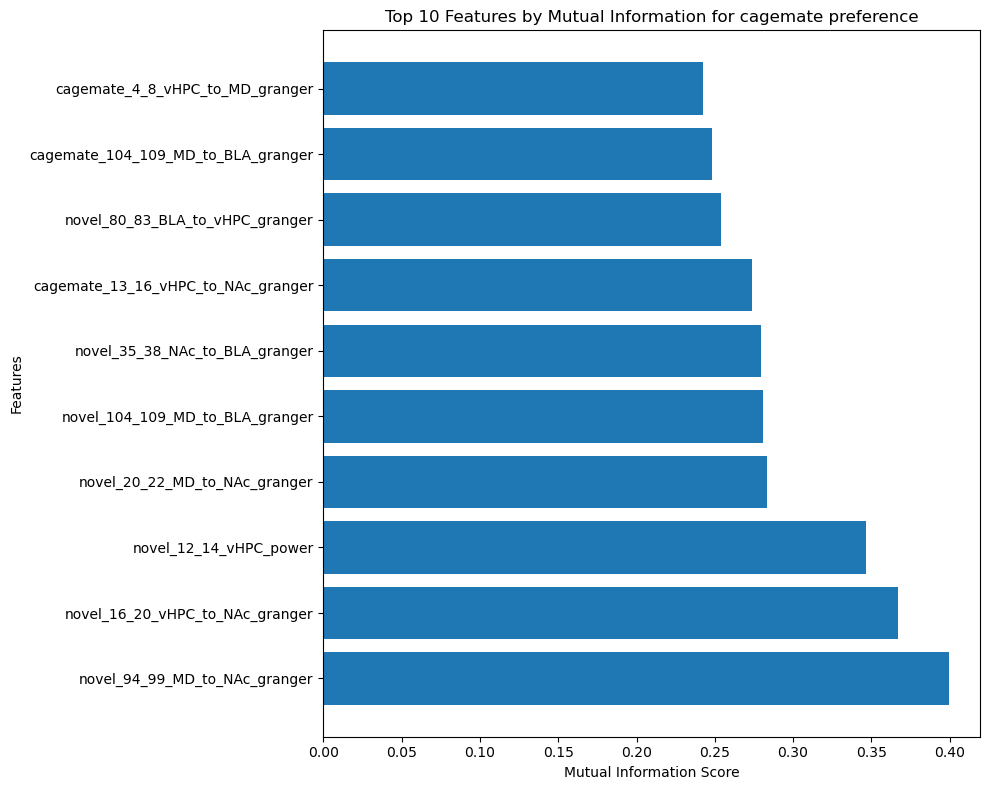

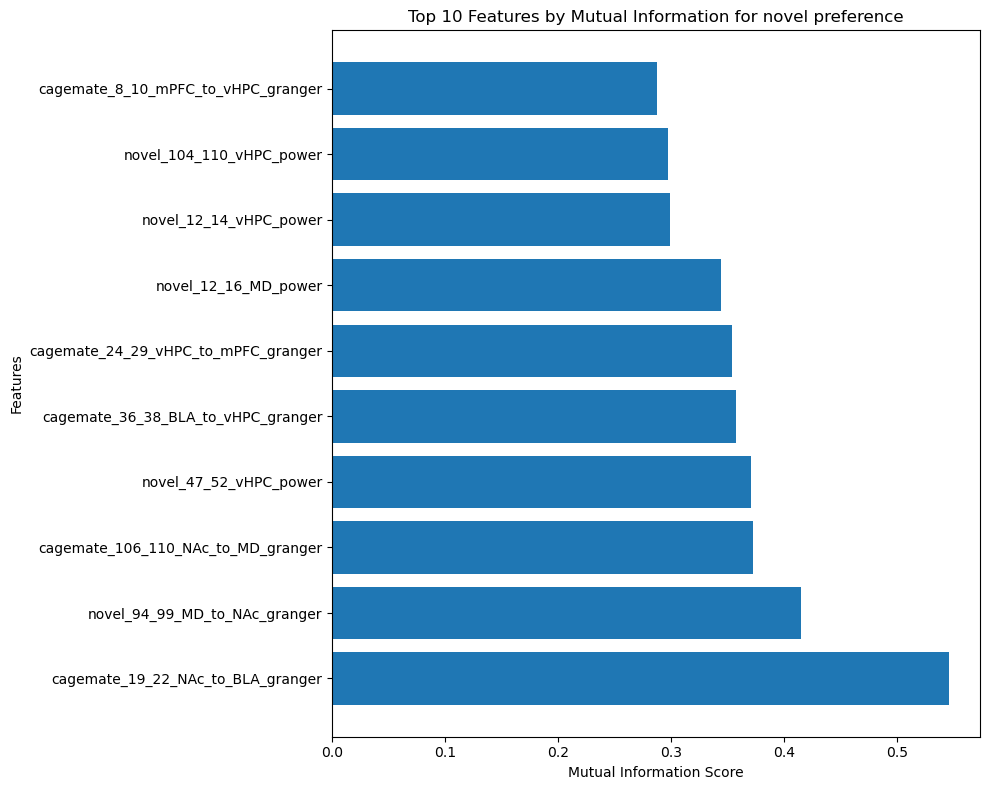

In [35]:

# Assume X contains your 500+ neural features and y is behavioral outcome
# X shape: (n_samples, n_features)
# y shape: (n_samples,)
X = lfp_df 
all_mi_results = pd.DataFrame()
for column_name in ['cagemate preference', 'novel preference']:
    y = event_total_time[column_name]
    # Calculate mutual information between each feature and target
    mi_scores = mutual_info_regression(X, y)
    mi_df = pd.DataFrame({'Feature': X.columns, 
                              column_name: mi_scores})
    mi_df = mi_df.sort_values(column_name, ascending=False).reset_index(drop=True)
    if not all_mi_results.empty:
    # Create DataFrame for better analysis
        all_mi_results = pd.merge(all_mi_results, mi_df, on='Feature')
    else:
        all_mi_results= mi_df
        
    # Visualize MI scores
    plt.figure(figsize=(10, 8))  # Adjusted figsize for better horizontal display
    plt.barh(mi_df['Feature'][:10], mi_df[column_name][:10])  # Use barh instead of bar
    plt.ylabel('Features')  # This becomes the y-axis label now
    plt.xlabel('Mutual Information Score')  # This becomes the x-axis label
    plt.title(f'Top 10 Features by Mutual Information for {column_name}')
    plt.tight_layout()

all_mi_results
